# Projet: Prédiction de la demande énergétique

**IFT3395/IFT6390 - Fondements de l'apprentissage machine**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pierrelux/mlbook/blob/main/exercises/projet_energie.ipynb)

**Compétition Kaggle:** [Rejoindre la compétition](https://www.kaggle.com/t/72daeb9bff104caf912f9a0b0f42eb5a)

---

## Contexte

Hydro-Québec publie des données ouvertes sur la consommation électrique de clients participant à un programme de gestion de la demande. Ces données incluent la consommation horaire, les conditions météorologiques, et des indicateurs d'événements de pointe.

Votre mission: construire un modèle de prédiction de la consommation énergétique en utilisant **uniquement** les méthodes vues dans les chapitres 1 à 5 du cours.

## Objectifs d'apprentissage

À la fin de ce projet, vous serez en mesure de:

1. Implémenter les moindres carrés ordinaires (OLS) à partir de zéro
2. Implémenter la régression logistique avec descente de gradient
3. Appliquer la régularisation Ridge et interpréter ses effets
4. Construire un modèle à deux étages: classification → régression
5. Utiliser les probabilités prédites comme caractéristiques

## Évaluation

| Composante | Pondération | Description |
|------------|-------------|-------------|
| **Entrevue orale** | **60%** | Vérification de la compréhension |
| Code soumis | 20% | Complétion des parties 1-7 |
| Kaggle | 10% | Position au classement |
| Rapport écrit | 10% | Analyse et réflexion |

### Barème de l'entrevue orale (60%)

| Critère | Points | Ce qu'on évalue |
|---------|--------|-----------------|
| Dérivation OLS au tableau | 15 | Maîtrise de la solution analytique |
| Explication descente de gradient | 10 | Compréhension des mises à jour |
| Justification des choix | 15 | Pourquoi ces caractéristiques? Pourquoi TimeSeriesSplit? |
| Questions théoriques | 10 | Ridge = MAP, entropie croisée, etc. |
| Modifications en direct | 10 | Adapter le code et prédire les effets |

**Important**: L'entrevue orale est la composante principale de l'évaluation. Vous devez être capable d'expliquer et de justifier chaque ligne de code que vous soumettez.

### ⚠️ Avertissement sur l'utilisation d'outils IA

Les outils comme ChatGPT, Cursor, Copilot peuvent vous aider, **mais** :
- Vous devez comprendre **chaque ligne** de code que vous soumettez
- L'entrevue orale révélera rapidement si vous comprenez ou non
- **60% de la note** dépend de votre capacité à expliquer votre travail

**Conseil** : Utilisez ces outils pour apprendre, pas pour éviter d'apprendre. Du code copié sans compréhension mène à l'échec à l'entrevue orale.

---

## Partie 0: Configuration et chargement des données

Exécutez cette cellule pour importer les bibliothèques et charger les données.

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
import meteostat as ms
import seaborn as sns
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

print("Configuration terminée!")

Configuration terminée!


### Chargement des données

Les données proviennent du jeu de données ouvert [consommation-clients-evenements-pointe](https://donnees.hydroquebec.com/explore/dataset/consommation-clients-evenements-pointe/) d'Hydro-Québec. Nous les chargeons directement depuis GitHub.

In [134]:
# URLs des données sur GitHub
BASE_URL = "https://raw.githubusercontent.com/pierrelux/mlbook/main/data/"

# Charger les données
print("Chargement des données depuis GitHub...")
train = pd.read_csv(BASE_URL + "energy_train.csv", parse_dates=['horodatage_local'])

# Pour l'évaluation locale: test avec la cible (energie_kwh)
test = pd.read_csv(BASE_URL + "energy_test_avec_cible.csv", parse_dates=['horodatage_local'])

# Pour Kaggle: test sans la cible (pour générer les prédictions)
test_kaggle = pd.read_csv(BASE_URL + "energy_test.csv", parse_dates=['horodatage_local'])

print(f"Ensemble d'entraînement: {len(train)} observations")
print(f"Ensemble de test: {len(test)} observations")
print(f"\nPériode d'entraînement: {train['horodatage_local'].min()} à {train['horodatage_local'].max()}")
print(f"Période de test: {test['horodatage_local'].min()} à {test['horodatage_local'].max()}")

Chargement des données depuis GitHub...
Ensemble d'entraînement: 8246 observations
Ensemble de test: 1754 observations

Période d'entraînement: 2022-01-01 05:00:00+00:00 à 2024-01-31 21:00:00+00:00
Période de test: 2024-02-01 01:00:00+00:00 à 2024-07-01 03:00:00+00:00


In [135]:
# Aperçu des données
print("Colonnes disponibles:")
print(train.columns.tolist())
print(f"\nProportion événements de pointe (train): {train['evenement_pointe'].mean():.1%}")
train.head()

Colonnes disponibles:
['horodatage_local', 'poste', 'heure', 'jour', 'mois', 'jour_semaine', 'temperature_ext', 'humidite', 'vitesse_vent', 'neige', 'irradiance_solaire', 'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos', 'est_weekend', 'est_ferie', 'clients_connectes', 'tstats_intelligents_connectes', 'evenement_pointe', 'energie_kwh']

Proportion événements de pointe (train): 0.9%


,horodatage_local,poste,heure,jour,mois,jour_semaine,temperature_ext,humidite,vitesse_vent,neige,...,mois_sin,mois_cos,jour_semaine_sin,jour_semaine_cos,est_weekend,est_ferie,clients_connectes,tstats_intelligents_connectes,evenement_pointe,energie_kwh
0,2022-01-01 05:00:00+00:00,A,0,1,1,7,-1.2,92,0.5,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,60.931664
1,2022-01-01 06:00:00+00:00,A,1,1,1,7,-1.3,93,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,59.117008
2,2022-01-01 07:00:00+00:00,C,2,1,1,7,-1.2,93,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,35,220,0,142.911665
3,2022-01-01 08:00:00+00:00,A,3,1,1,7,-1.2,94,1.0,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,52.323657
4,2022-01-01 11:00:00+00:00,A,6,1,1,7,-1.0,97,1.5,0.0,...,0.5,0.866025,-2.450000e-16,1.0,1,1,17,118,0,78.351166


### Description des variables

Les données contiennent des mesures météorologiques et temporelles pour prédire la consommation énergétique.

In [136]:
# Description des variables
print("Variables météorologiques:")
print("  - temperature_ext: Température extérieure moyenne (°C)")
print("  - humidite: Humidité relative moyenne (%)")
print("  - vitesse_vent: Vitesse du vent moyenne (km/h)")
print("  - neige: Précipitations de neige moyennes")
print("  - irradiance_solaire: Irradiance solaire moyenne")

print("\nVariables temporelles:")
print("  - heure, mois, jour, jour_semaine: Composantes temporelles")
print("  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique")
print("  - est_weekend, est_ferie: Indicateurs binaires")

print("\nAutres:")
print("  - evenement_pointe: Indicateur d'événement de pointe (classification)")
print("  - energie_kwh: Variable cible (consommation en kWh)")

print(f"\nStatistiques de base:")
train[['temperature_ext', 'humidite', 'energie_kwh']].describe()

Variables météorologiques:
  - temperature_ext: Température extérieure moyenne (°C)
  - humidite: Humidité relative moyenne (%)
  - vitesse_vent: Vitesse du vent moyenne (km/h)
  - neige: Précipitations de neige moyennes
  - irradiance_solaire: Irradiance solaire moyenne

Variables temporelles:
  - heure, mois, jour, jour_semaine: Composantes temporelles
  - heure_sin, heure_cos, mois_sin, mois_cos: Encodage cyclique
  - est_weekend, est_ferie: Indicateurs binaires

Autres:
  - evenement_pointe: Indicateur d'événement de pointe (classification)
  - energie_kwh: Variable cible (consommation en kWh)

Statistiques de base:


,temperature_ext,humidite,energie_kwh
count,8246.000000,8246.000000,8246.000000
mean,5.982573,72.964831,215.906679
std,12.722433,18.063945,212.948127
min,-32.000000,16.000000,13.007400
25%,-2.600000,60.000000,90.226631
50%,5.300000,76.000000,169.503467
75%,17.000000,88.000000,294.907806
max,33.000000,100.000000,11804.198070


In [137]:
# IMPORTANT: Division temporelle déjà effectuée
# Les données de test couvrent la période à partir du 1er février 2024
# NE PAS mélanger les données - c'est une série temporelle!

print("⚠️  ATTENTION: Division temporelle")
print("Les ensembles train/test sont déjà séparés chronologiquement.")
print("N'utilisez PAS de validation croisée aléatoire (fuite d'information).")
print("\nPour la validation, utilisez une division temporelle sur train:")
print("  - Ex: train[:6000] pour entraînement, train[6000:] pour validation")

# Note: il y a un décalage de distribution entre train (hiver) et test (printemps/été)
# C'est un défi réaliste! Pensez à utiliser des caractéristiques qui généralisent bien.
print("\n📊 Décalage de distribution:")
print(f"  Train: {train['energie_kwh'].mean():.1f} kWh (hiver)")
print(f"  Test:  {test['energie_kwh'].mean():.1f} kWh (printemps/été)")
print("  → Le modèle doit généraliser à travers les saisons!")

⚠️  ATTENTION: Division temporelle
Les ensembles train/test sont déjà séparés chronologiquement.
N'utilisez PAS de validation croisée aléatoire (fuite d'information).

Pour la validation, utilisez une division temporelle sur train:
  - Ex: train[:6000] pour entraînement, train[6000:] pour validation

📊 Décalage de distribution:
  Train: 215.9 kWh (hiver)
  Test:  83.7 kWh (printemps/été)
  → Le modèle doit généraliser à travers les saisons!


### Exploration visuelle

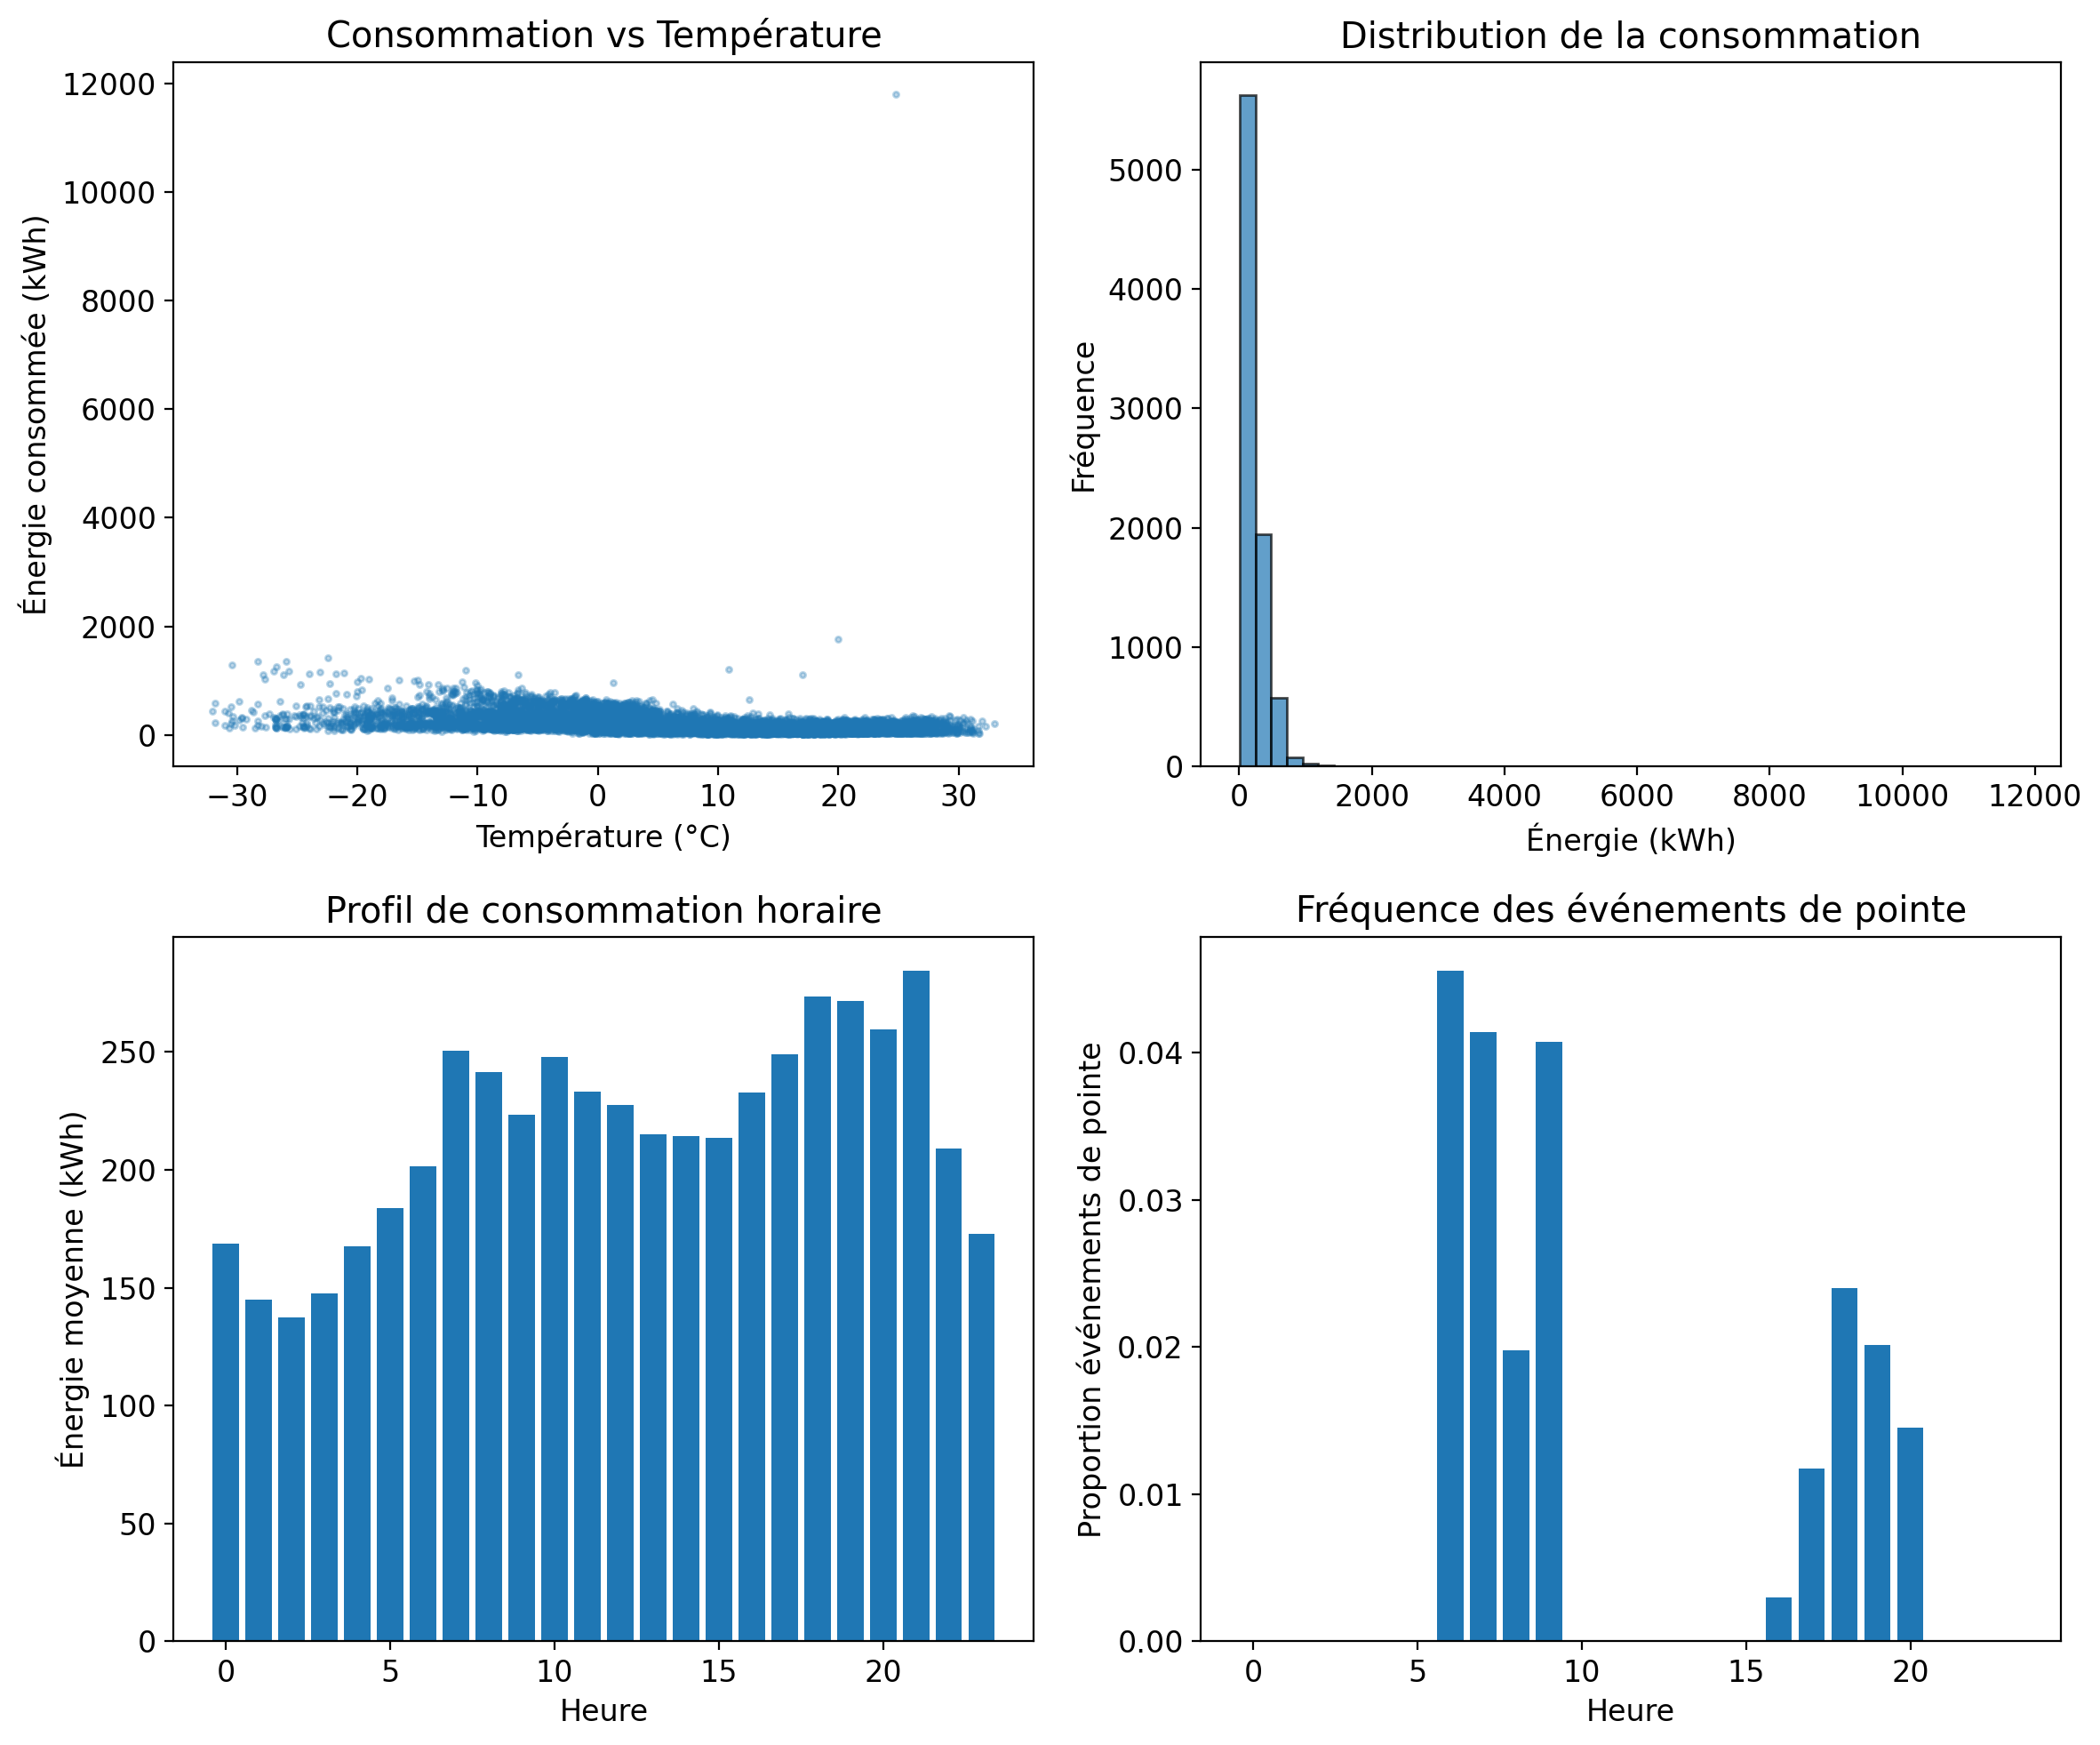

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Consommation vs température
axes[0, 0].scatter(train['temperature_ext'], train['energie_kwh'], alpha=0.3, s=5)
axes[0, 0].set_xlabel('Température (°C)')
axes[0, 0].set_ylabel('Énergie consommée (kWh)')
axes[0, 0].set_title('Consommation vs Température')

# Distribution de la consommation
axes[0, 1].hist(train['energie_kwh'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Énergie (kWh)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution de la consommation')

# Profil horaire
profil_horaire = train.groupby('heure')['energie_kwh'].mean()
axes[1, 0].bar(profil_horaire.index, profil_horaire.values)
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Énergie moyenne (kWh)')
axes[1, 0].set_title('Profil de consommation horaire')

# Événements de pointe par heure
pointe_horaire = train.groupby('heure')['evenement_pointe'].mean()
axes[1, 1].bar(pointe_horaire.index, pointe_horaire.values)
axes[1, 1].set_xlabel('Heure')
axes[1, 1].set_ylabel('Proportion événements de pointe')
axes[1, 1].set_title('Fréquence des événements de pointe')

plt.tight_layout()

Text(0.5, 1.0, 'Distribution de la log-consommation')

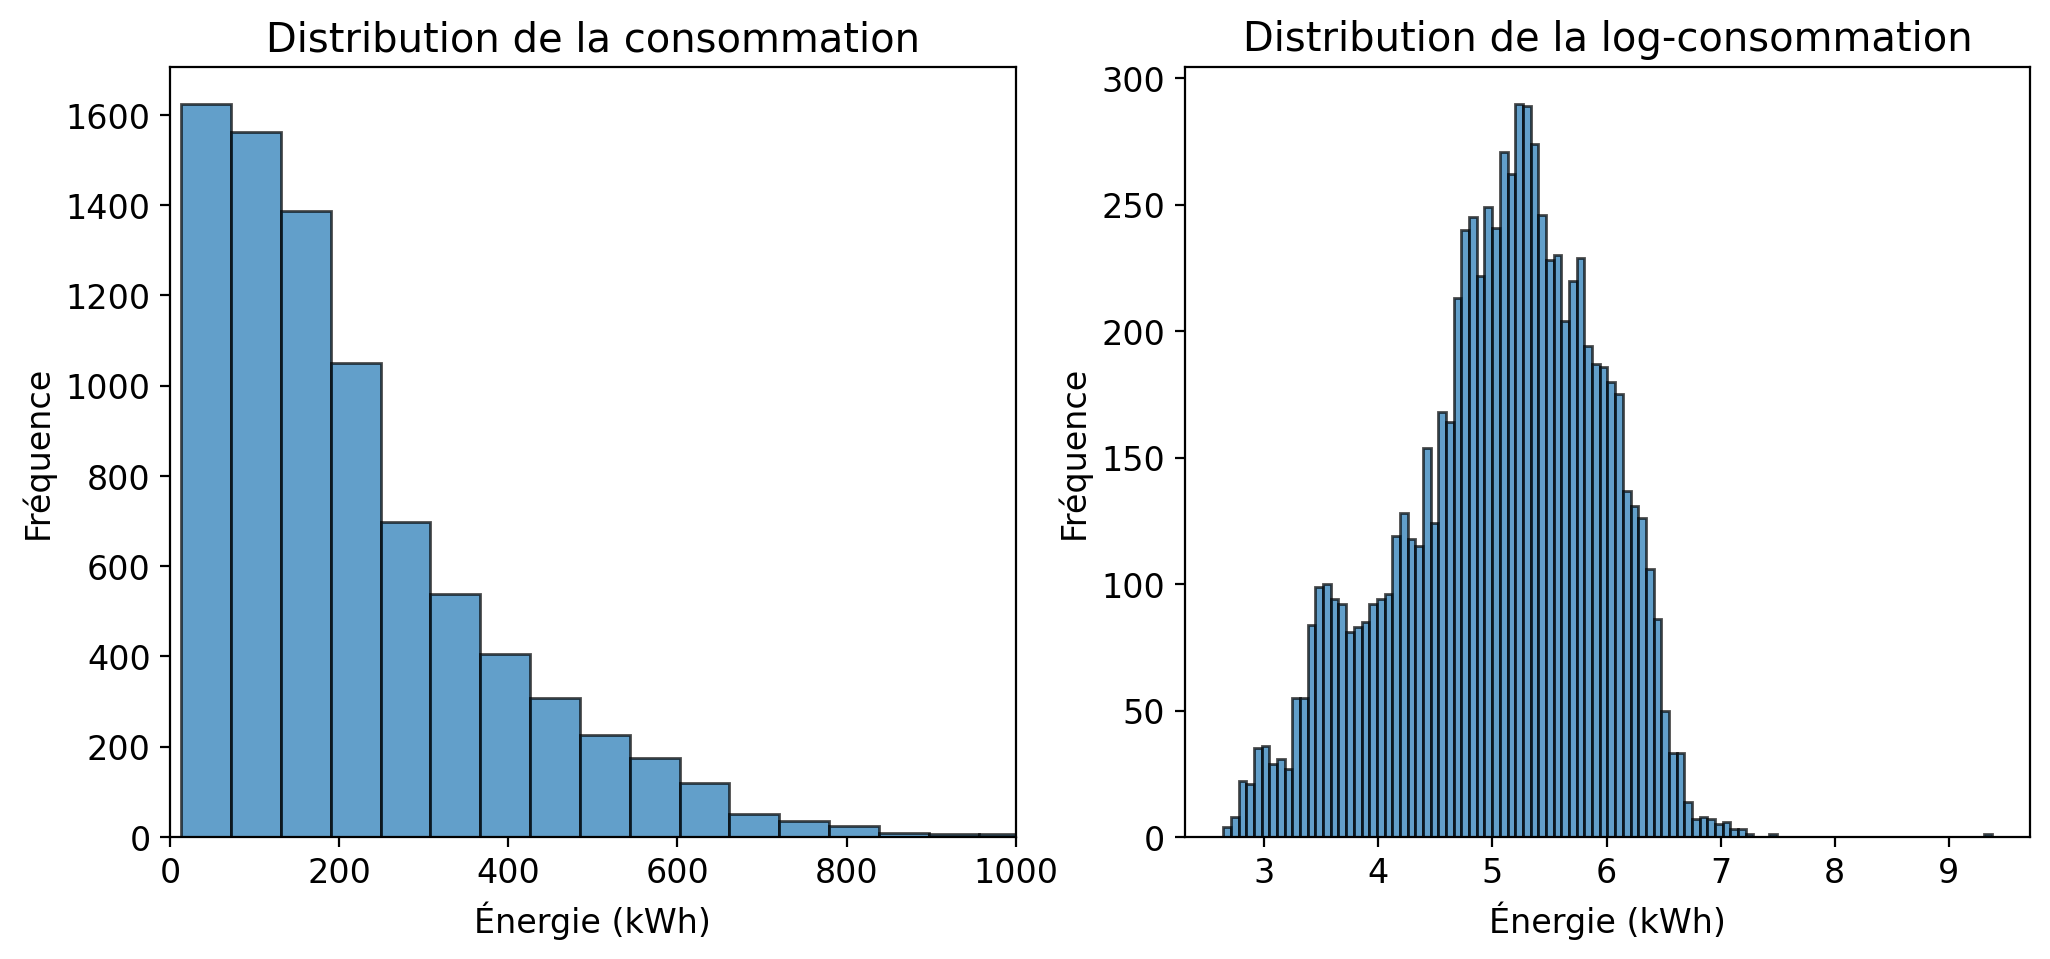

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# distribution de la consommation
axes[0].hist(train['energie_kwh'], bins=200, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Énergie (kWh)')
axes[0].set_ylabel('Fréquence')
axes[0].set_xlim(0, 1000)
axes[0].set_title('Distribution de la consommation')
# distribution de la log consommation
axes[1].hist(np.log1p(train['energie_kwh']), bins=100, edgecolor='black', alpha=0.7) 
axes[1].set_xlabel('Énergie (kWh)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution de la log-consommation')

In [140]:
variables_a_plotter = train.columns.drop(['horodatage_local', 'poste', 'energie_kwh', 'evenement_pointe'])
print("Variables à analyser:", variables_a_plotter)


Variables à analyser: Index(['heure', 'jour', 'mois', 'jour_semaine', 'temperature_ext', 'humidite',
       'vitesse_vent', 'neige', 'irradiance_solaire', 'heure_sin', 'heure_cos',
       'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos',
       'est_weekend', 'est_ferie', 'clients_connectes',
       'tstats_intelligents_connectes'],
      dtype='str')


In [141]:
# sortir les variables ayant une correlation d'au moins 10% avec la consommation:
df = train.copy()
df['energie_kwh_log'] = np.log1p(df['energie_kwh'])
vars_to_keep = df[list(variables_a_plotter) + ['energie_kwh_log']].corr()['energie_kwh_log'].abs().sort_values(ascending=False).loc[lambda x: x >= 0.1].index.tolist()
print("Variables à garder (corrélation >= 0.1):")
print(vars_to_keep)


Variables à garder (corrélation >= 0.1):
['energie_kwh_log', 'mois_cos', 'clients_connectes', 'tstats_intelligents_connectes', 'temperature_ext', 'heure', 'irradiance_solaire', 'heure_cos', 'heure_sin', 'mois_sin', 'neige']


Text(0.5, 1.0, 'Sélection du degré par validation')

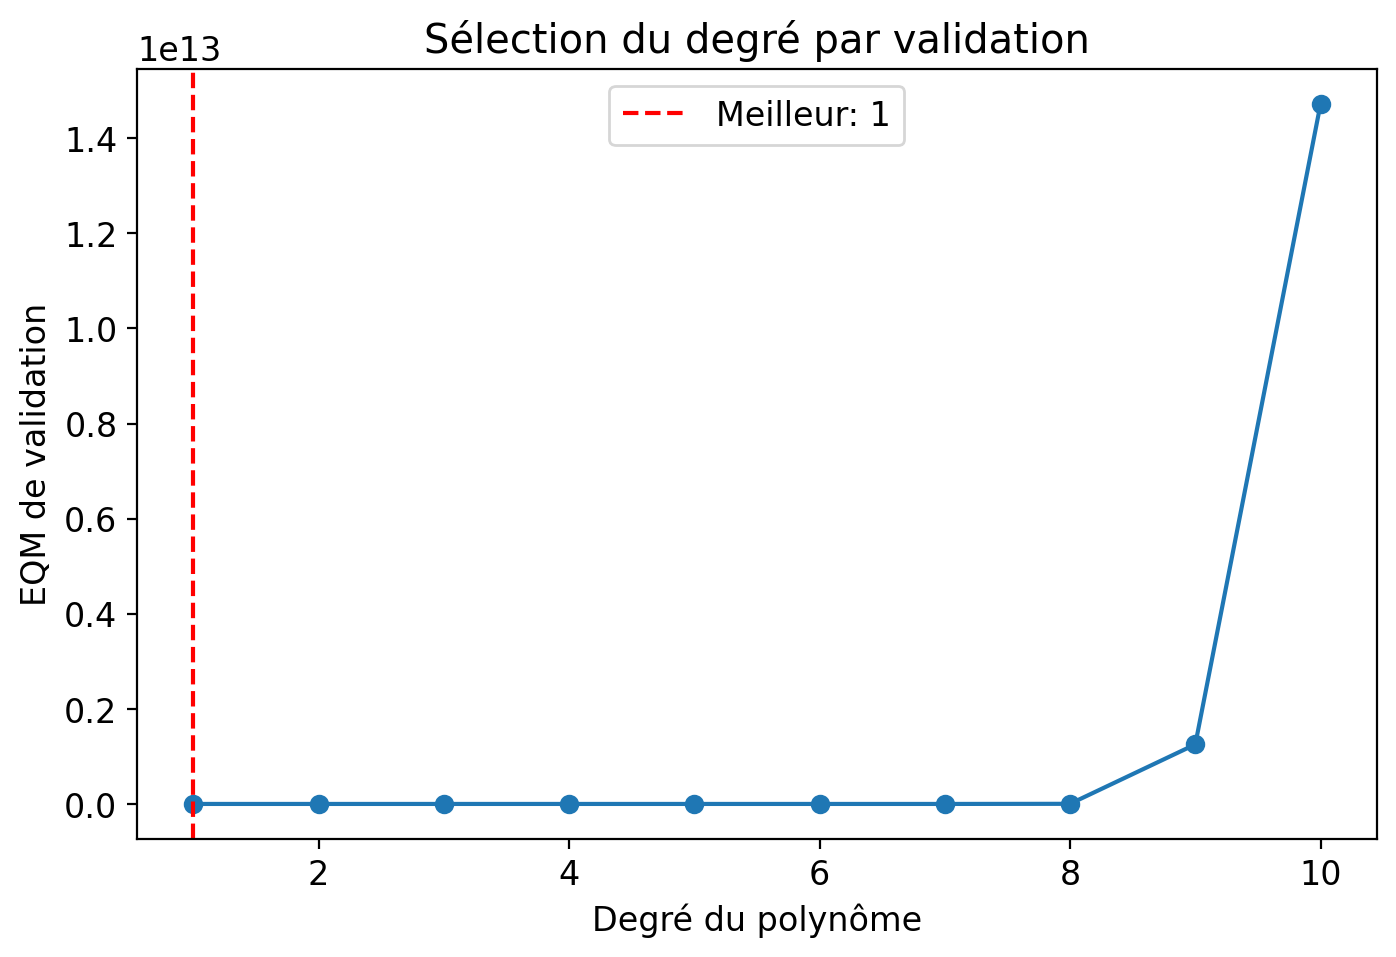

In [142]:
# choix des dégrés de polynomes pour certaines variables:
var ='neige'
df = train.copy()
df['energie_kwh_log'] = np.log1p(df['energie_kwh'])
x_train, y_train = df[:6000].loc[:, var].values, df[:6000]['energie_kwh_log'].values
x_val, y_val = df[6000:].loc[:, var].values, df[6000:]['energie_kwh_log'].values

degrees = range(1, 11)
val_errors = []

for deg in degrees:
    coeffs = np.polyfit(x_train, y_train, deg)
    y_pred_val = np.polyval(coeffs, x_val)
    val_errors.append(np.mean((y_val - y_pred_val)**2))

best_degree = degrees[np.argmin(val_errors)]

plt.figure(figsize=(8, 5))
plt.plot(degrees, val_errors, 'o-')
plt.axvline(best_degree, color='r', linestyle='--', label=f'Meilleur: {best_degree}')
plt.xlabel('Degré du polynôme')
plt.ylabel('EQM de validation')
plt.legend()
plt.title('Sélection du degré par validation')

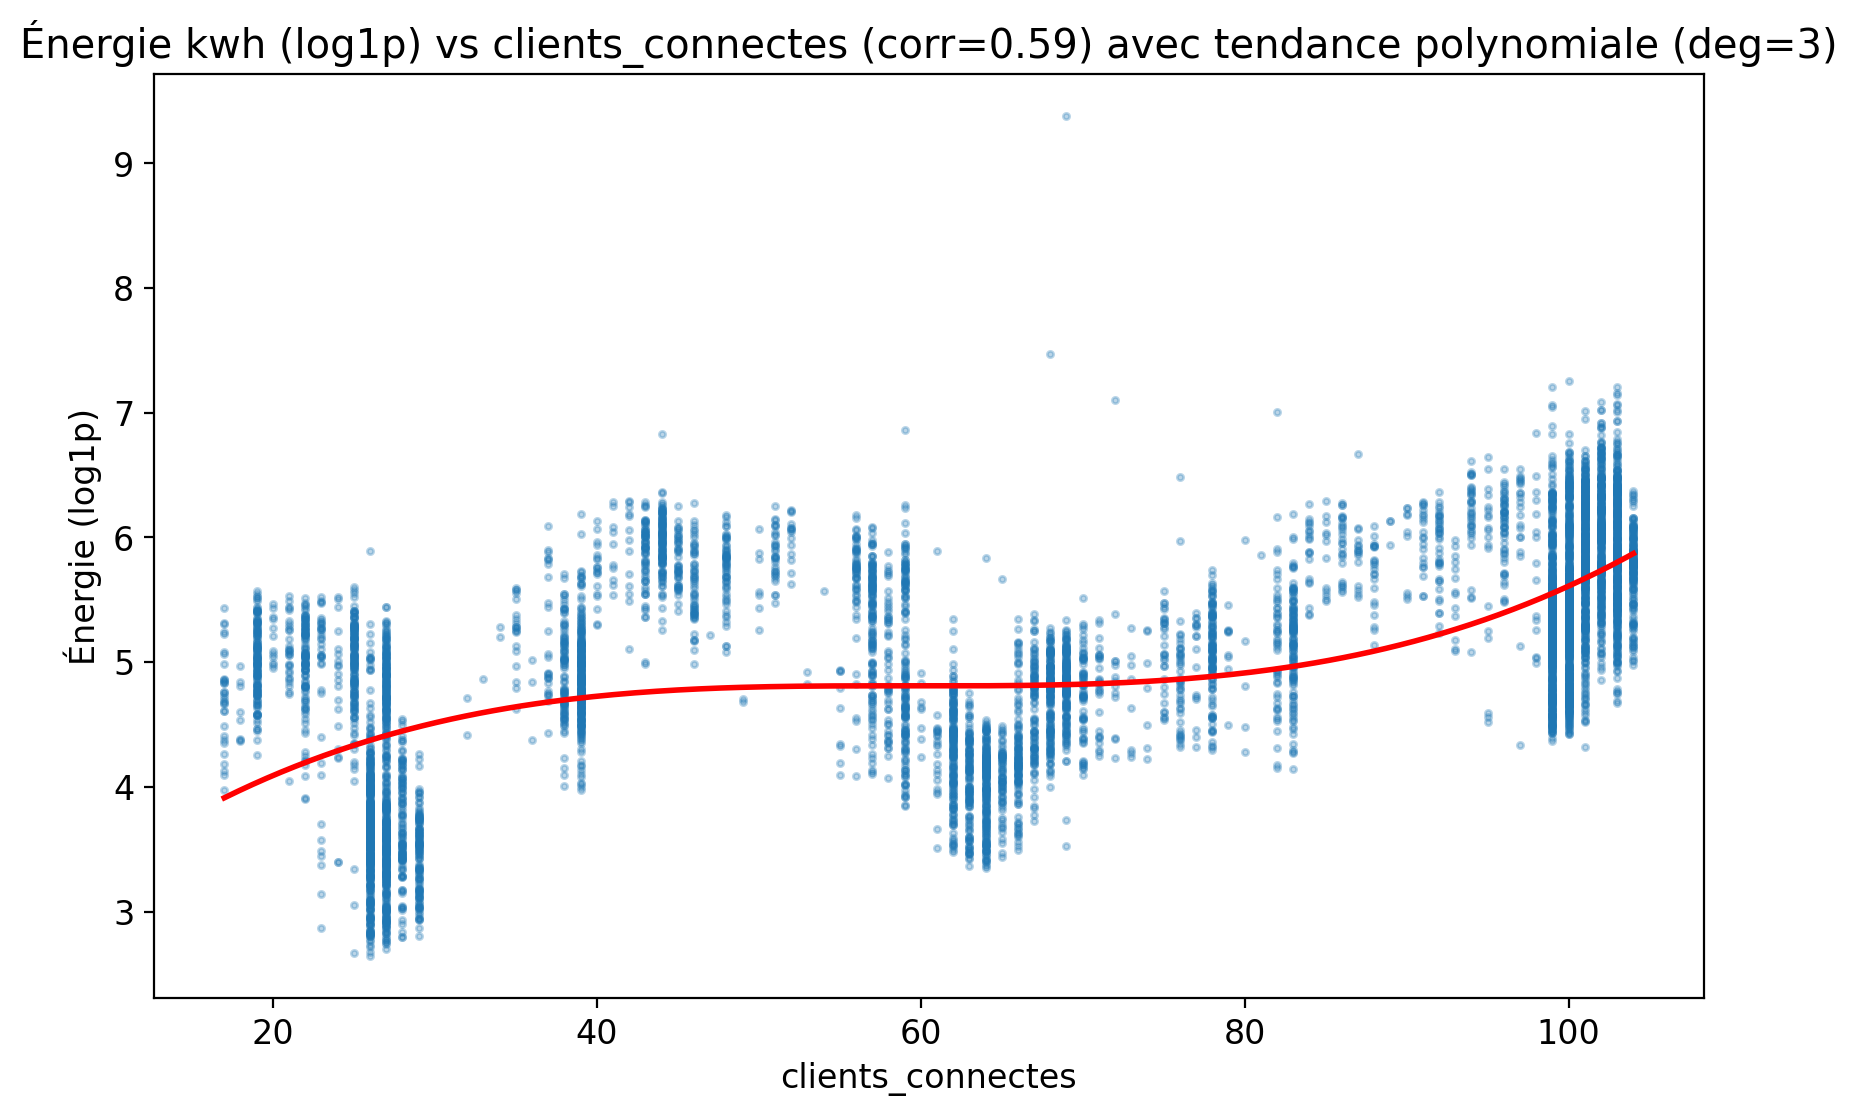

In [143]:
var = 'clients_connectes'
df = train.copy()
df['energie_kwh_log'] = np.log1p(df['energie_kwh'])
x = df[var]
y = df['energie_kwh_log']  
deg = 3

# Ajustement polynomial
coeffs = np.polyfit(x, y, deg=deg)
poly_eq = np.poly1d(coeffs)

# Valeurs pour tracer la courbe
x_range = np.linspace(x.min(), x.max(), 200)
y_pred = poly_eq(x_range)

# Plot
plt.figure()
plt.scatter(x, y, alpha=0.3, s=5)
plt.plot(x_range, y_pred, color='red', linewidth=2)
plt.xlabel(var)
plt.ylabel("Énergie (log1p)")
corr = np.corrcoef(train[var], np.log1p(train['energie_kwh']))[0,1]
plt.title(f'Énergie kwh (log1p) vs {var} (corr={corr:.2f}) avec tendance polynomiale (deg={deg})')
plt.show()


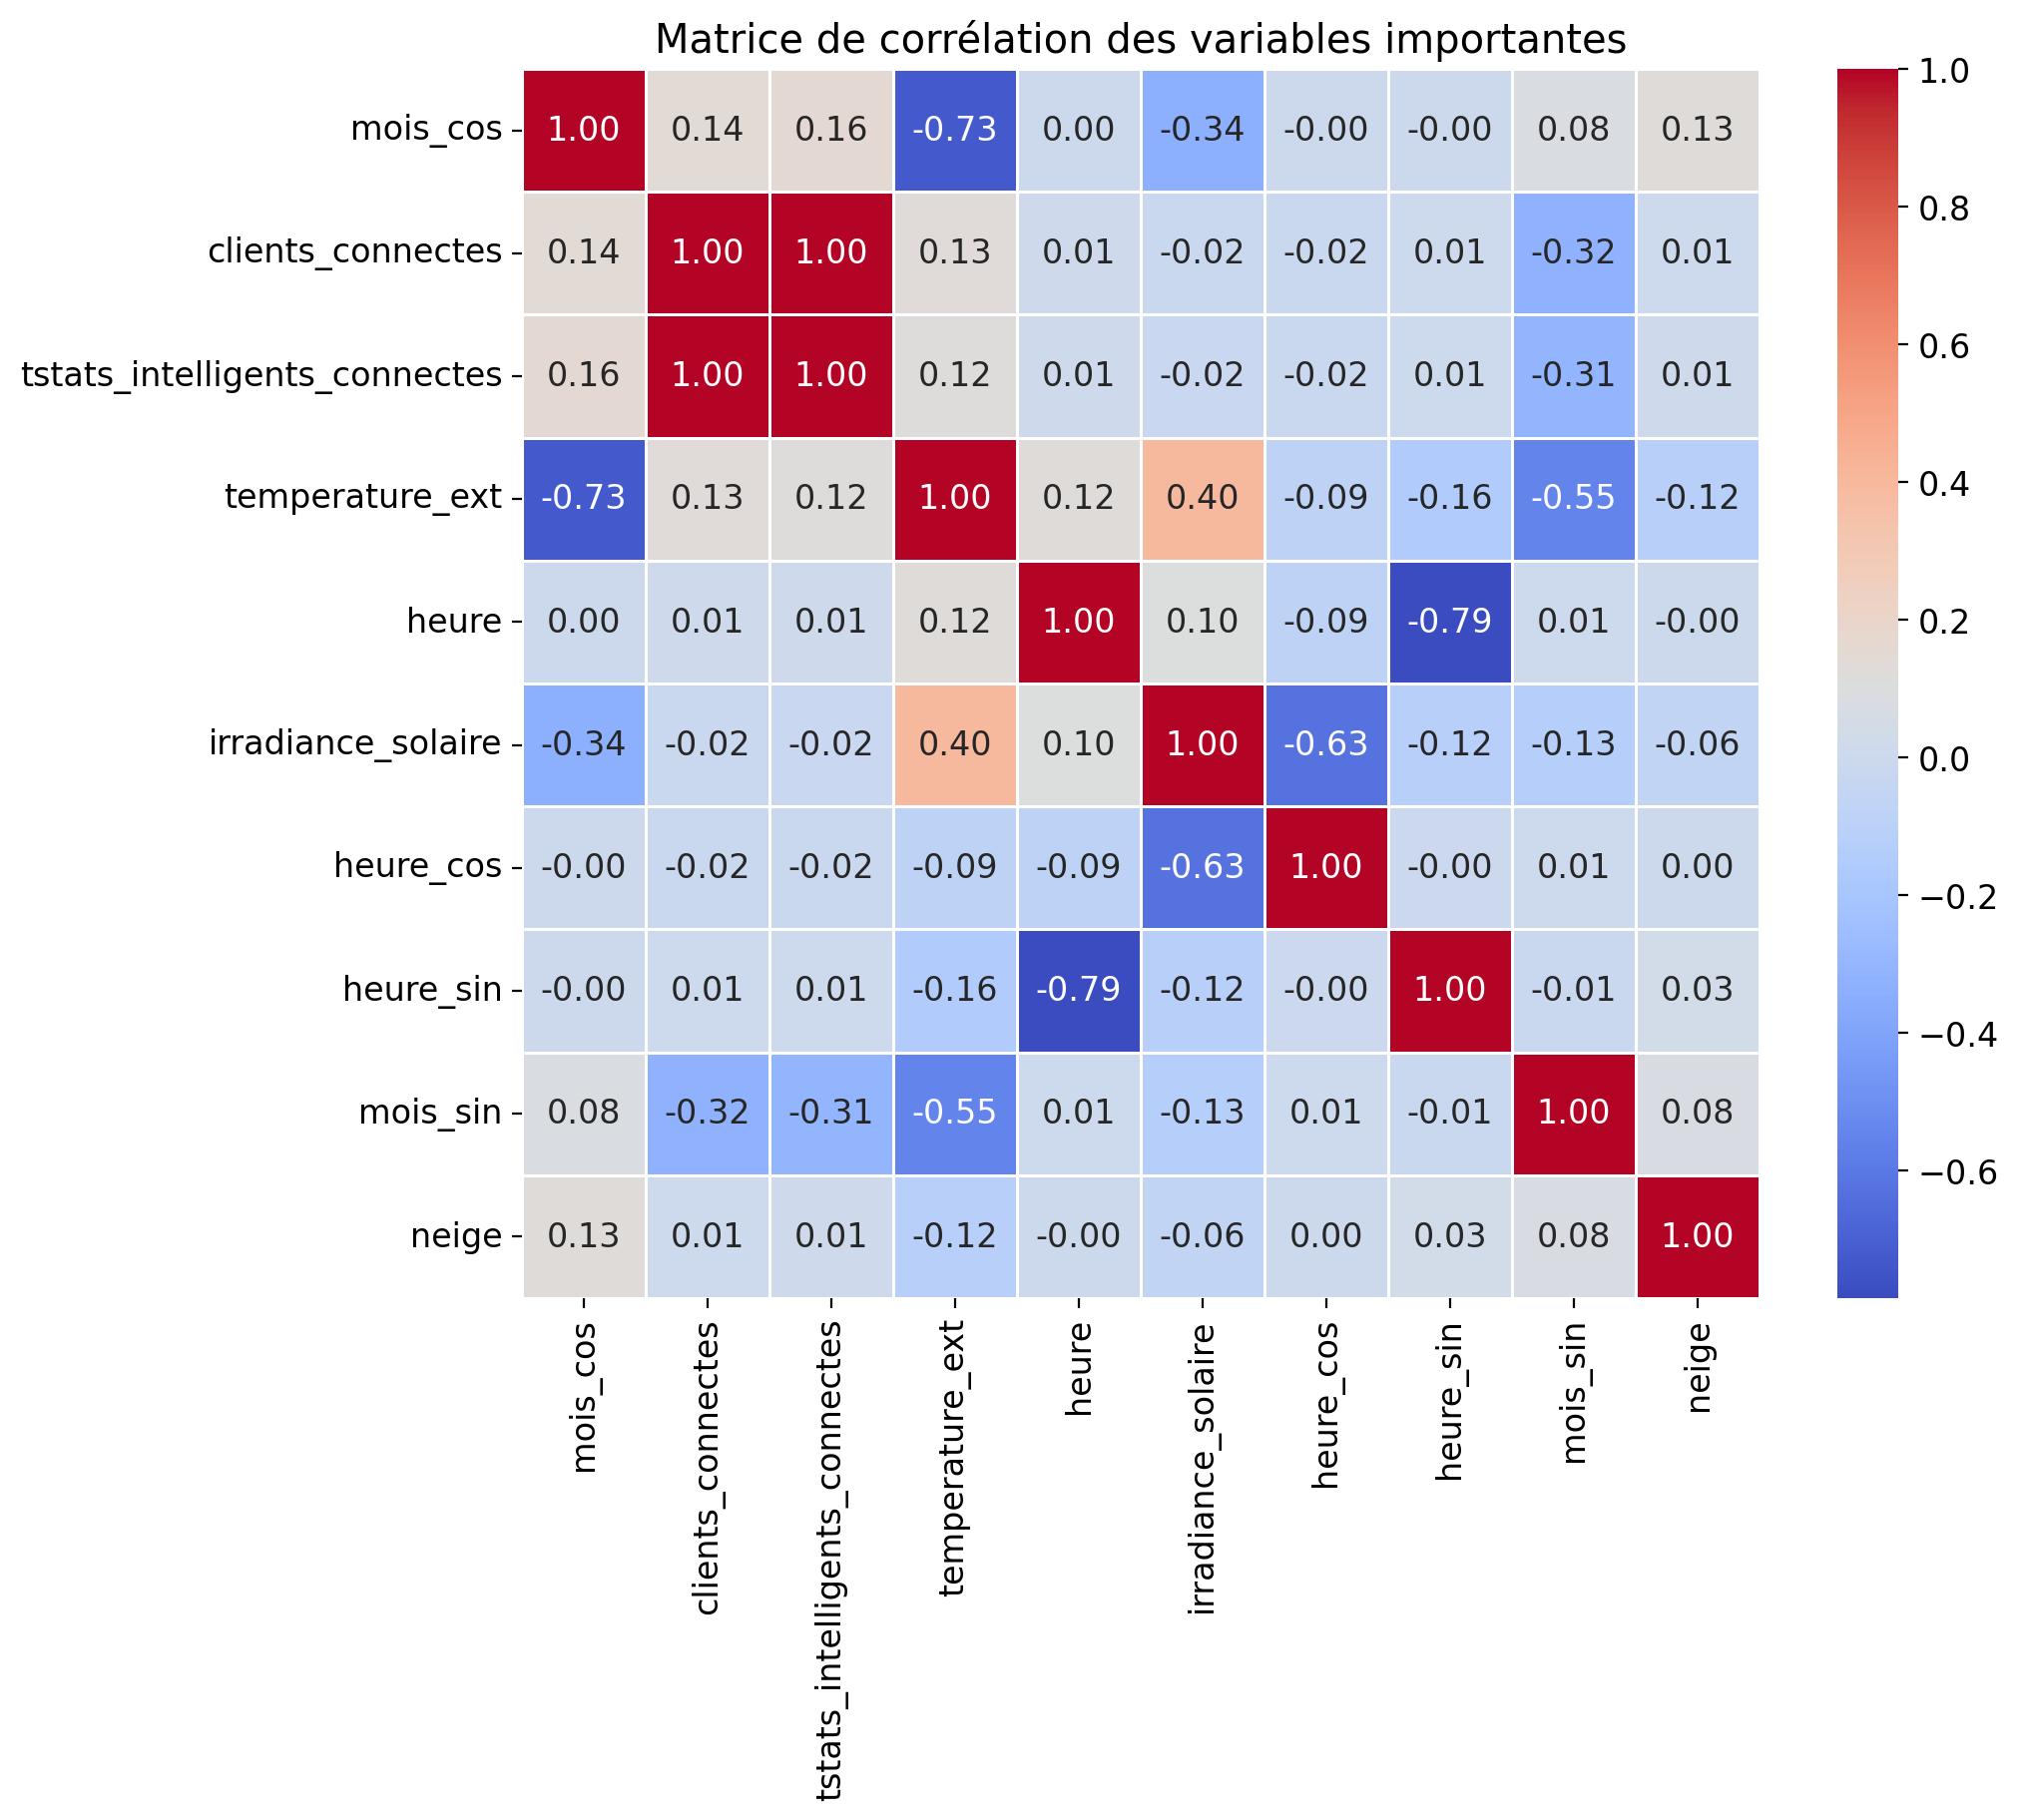

In [144]:
# correlation entre les variables importantes:
important_vars = vars_to_keep[1:]  # exclure la cible
corr_matrix = df[important_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des variables importantes")
plt.show()

evenement_pointe
0    99.054087
1     0.945913
Name: proportion, dtype: float64

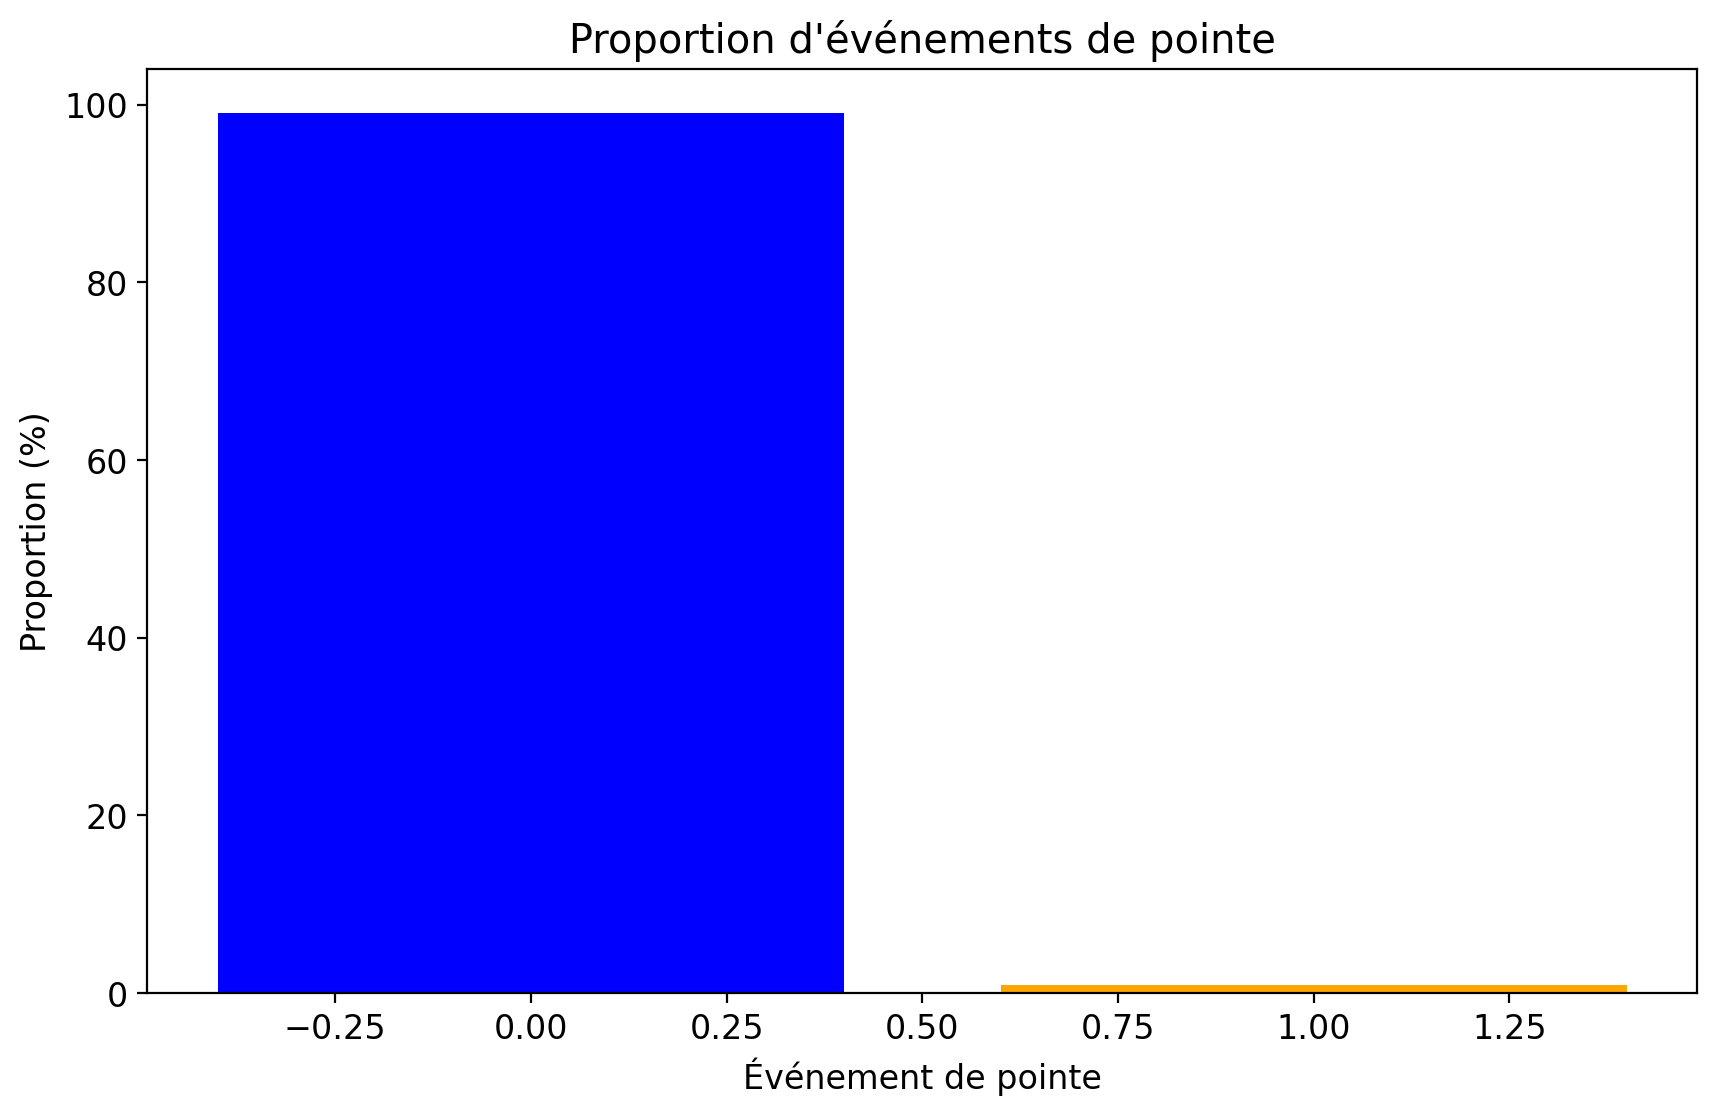

In [145]:
# diagramme à barre de l'évenement de pointe
p = train['evenement_pointe'].value_counts(normalize=True) * 100
plt.figure()
plt.bar(p.index, p.values, color=['blue', 'orange'])
plt.xlabel('Événement de pointe')
plt.ylabel('Proportion (%)')
plt.title('Proportion d\'événements de pointe')
p

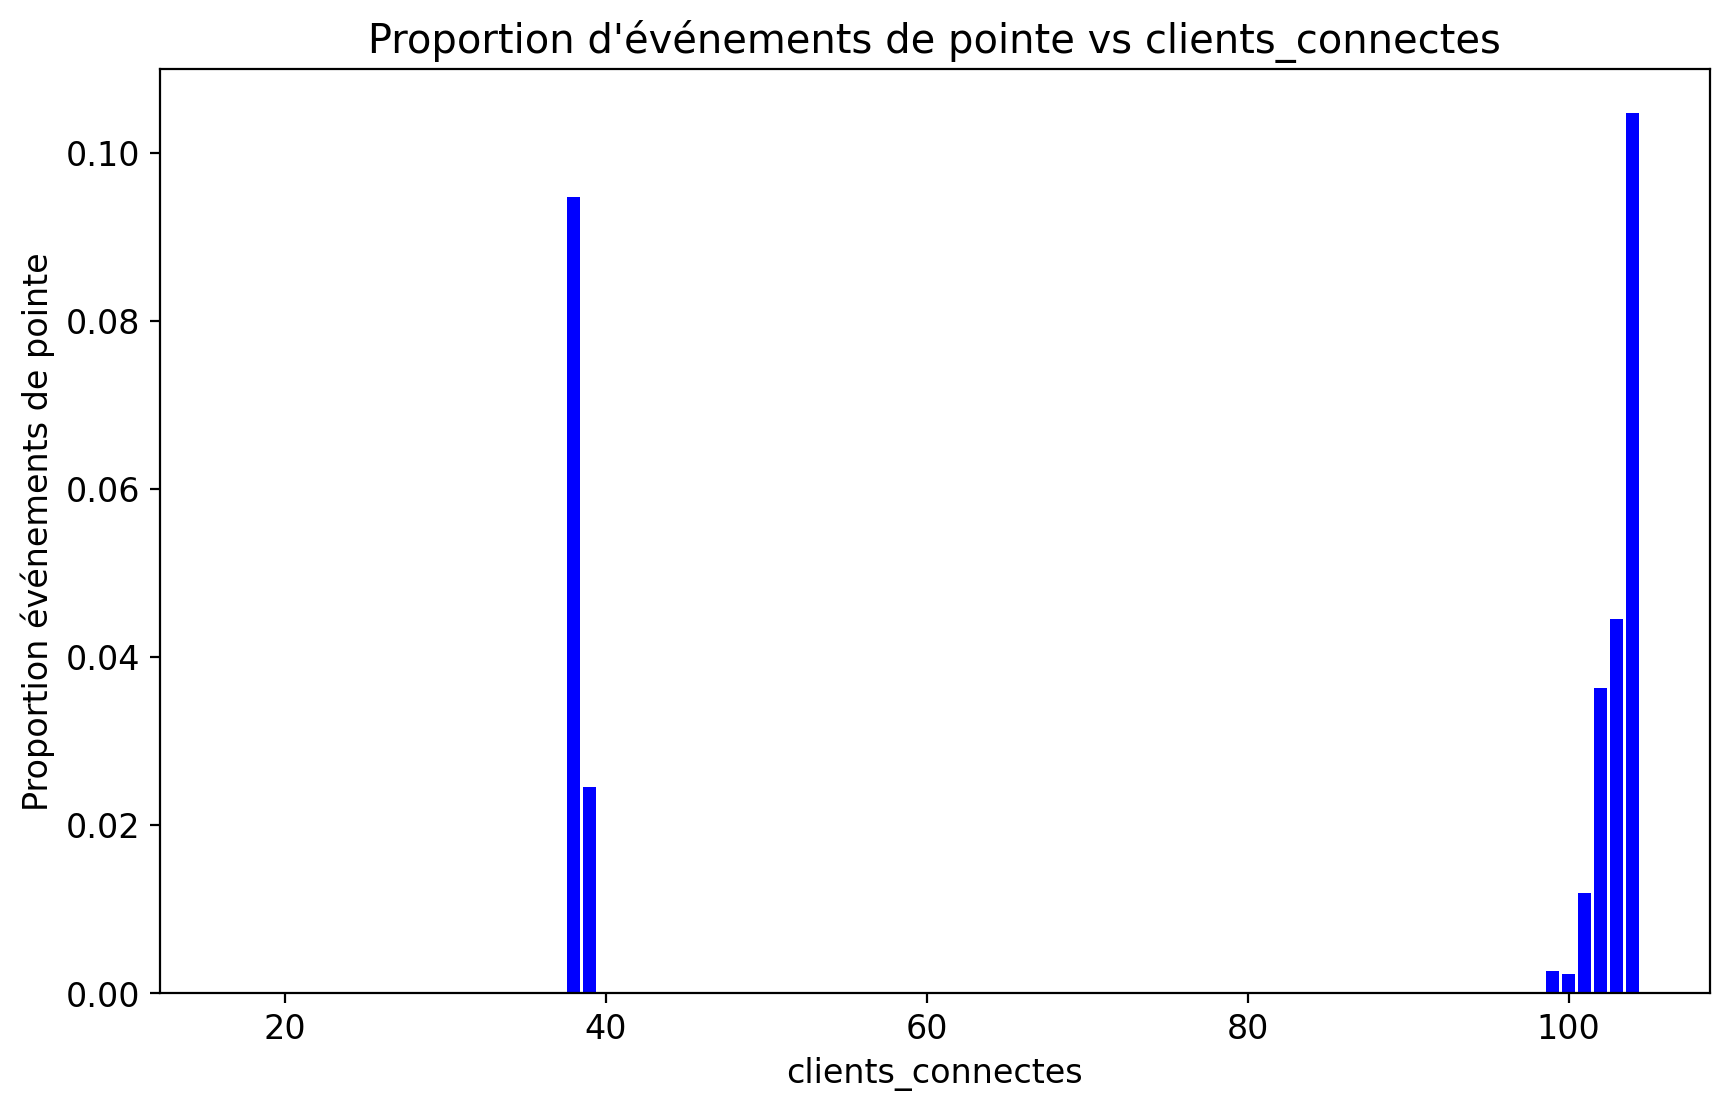

In [146]:
var = 'clients_connectes'
x = train.groupby(var)['evenement_pointe'].mean()
plt.figure()
plt.bar(x.index, x.values, color='blue')
plt.xlabel(var)
plt.ylabel('Proportion événements de pointe')
plt.title(f'Proportion d\'événements de pointe vs {var}')
plt.show()

---

## Partie 1: Implémentation OLS (10%)

Avant d'utiliser scikit-learn, vous devez implémenter la solution analytique des moindres carrés ordinaires.

**Rappel**: La solution OLS est donnée par:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

Pour des raisons de stabilité numérique, préférez `np.linalg.solve` à l'inversion directe.

In [147]:
def ols_fit(X, y):
    """
    Calcule les coefficients OLS.
    
    Paramètres: 
        X : ndarray de forme (n, p) - matrice de caractéristiques (SANS colonne de 1)
        y : ndarray de forme (n,) - vecteur cible
    
    Retourne:
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, coef2, ...]
    
    Indice: Ajoutez une colonne de 1 à X pour l'intercept.
    """
    # VOTRE CODE ICI
    # 1. Ajouter une colonne de 1 pour l'intercept
    # 2. Résoudre le système X^T X beta = X^T y
    # 3. Retourner beta

    n = X.shape[0]
    X_b = np.hstack((np.ones((n, 1)), X))
    beta = np.linalg.solve(X_b.T @ X_b, X_b.T @ y)
    return beta


def ols_predict(X, beta):
    """
    Prédit avec les coefficients OLS.
    
    Paramètres:
        X : ndarray de forme (n, p) - caractéristiques (SANS colonne de 1)
        beta : ndarray de forme (p+1,) - coefficients [intercept, coef1, ...]
    
    Retourne:
        y_pred : ndarray de forme (n,)
    """
    # VOTRE CODE ICI
    
    n = X.shape[0]
    X_b = np.hstack((np.ones((n, 1)), X))
    y_pred = X_b @ beta
    return y_pred


In [148]:
# Test de votre implémentation
# Caractéristiques simples pour commencer
features_base = ['temperature_ext', 'humidite', 'vitesse_vent']

X_train_base = train[features_base].values
y_train = train['energie_kwh'].values
X_test_base = test[features_base].values
y_test = test['energie_kwh'].values

# Votre implémentation
beta_ols = ols_fit(X_train_base, y_train)
y_pred_ols = ols_predict(X_test_base, beta_ols) if beta_ols is not None else None

# Validation avec sklearn
model_sklearn = LinearRegression()
model_sklearn.fit(X_train_base, y_train)
y_pred_sklearn = model_sklearn.predict(X_test_base)

# Comparaison (s'affiche une fois ols_fit et ols_predict implémentés)
if beta_ols is not None and y_pred_ols is not None:
    print("Comparaison OLS implémenté vs sklearn:")
    print(f"  Intercept - Vous: {beta_ols[0]:.4f}, sklearn: {model_sklearn.intercept_:.4f}")
    print(f"  Coefficients proches: {np.allclose(beta_ols[1:], model_sklearn.coef_, atol=1e-4)}")
    print(f"\nR² sur test: {r2_score(y_test, y_pred_ols):.4f}")
else:
    print("Complétez ols_fit et ols_predict (Partie 1) pour voir la comparaison.")

Comparaison OLS implémenté vs sklearn:
  Intercept - Vous: 234.8557, sklearn: 234.8557
  Coefficients proches: True

R² sur test: -2.2572


---

## Partie 2: Régression logistique avec descente de gradient (15%)

Implémentez la régression logistique pour la classification binaire.

**Rappels**:
- Fonction sigmoïde: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Perte d'entropie croisée: $L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1-y_i) \log(1-p_i) \right]$
- Gradient: $\nabla L = \frac{1}{n} \mathbf{X}^\top (\sigma(\mathbf{X}\boldsymbol{\beta}) - \mathbf{y})$

In [149]:
def sigmoid(z):
    """
    Fonction sigmoïde.
    
    Indice: Pour la stabilité numérique, clip z entre -500 et 500.
    """
    # VOTRE CODE ICI
    
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    

def cross_entropy_loss(y_true, y_pred_proba):
    """
    Calcule la perte d'entropie croisée binaire.
    
    Indice: Clip les probabilités pour éviter log(0).
    """
    # VOTRE CODE ICI

    y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))


def logistic_gradient(X, y, beta):
    """
    Calcule le gradient de la perte d'entropie croisée.
    
    Paramètres:
        X : ndarray (n, p+1) - caractéristiques AVEC colonne de 1
        y : ndarray (n,) - étiquettes binaires
        beta : ndarray (p+1,) - coefficients actuels
    
    Retourne:
        gradient : ndarray (p+1,)
    """
    # VOTRE CODE ICI
    n = X.shape[0]
    y_pred_proba = sigmoid(X @ beta)
    return (X.T @ (y_pred_proba - y)) / n


def logistic_fit_gd(X, y, lr=0.1, n_iter=1000, verbose=False):
    """
    Entraîne la régression logistique par descente de gradient.
    
    Paramètres:
        X : ndarray (n, p) - caractéristiques SANS colonne de 1
        y : ndarray (n,) - étiquettes binaires (0 ou 1)
        lr : float - taux d'apprentissage
        n_iter : int - nombre d'itérations
        verbose : bool - afficher la progression
    
    Retourne:
        beta : ndarray (p+1,) - coefficients [intercept, coef1, ...]
        losses : list - historique des pertes
    """
    # VOTRE CODE ICI
    # 1. Ajouter colonne de 1 à X
    # 2. Initialiser beta à zéro
    # 3. Boucle de descente de gradient
    # 4. Retourner beta et historique des pertes
    n = X.shape[0]
    X_b = np.hstack((np.ones((n, 1)), X))
    p = X_b.shape[1]
    beta = np.zeros(p)
    losses = []     
    for i in range(n_iter):
        grad = logistic_gradient(X_b, y, beta)
        beta -= lr * grad
        y_pred_proba = sigmoid(X_b @ beta)
        loss = cross_entropy_loss(y, y_pred_proba)
        losses.append(loss)
        if (verbose and i == n_iter - 1):
            print(f"Iteration {i+1}/{n_iter}, Loss: {loss:.4f}")
    return beta, losses 


def logistic_predict_proba(X, beta):
    """
    Retourne les probabilités P(Y=1|X).
    """
    # VOTRE CODE ICI
    n = X.shape[0]
    X_b = np.hstack((np.ones((n, 1)), X))
    return sigmoid(X_b @ beta)

Iteration 500/500, Loss: 0.0570


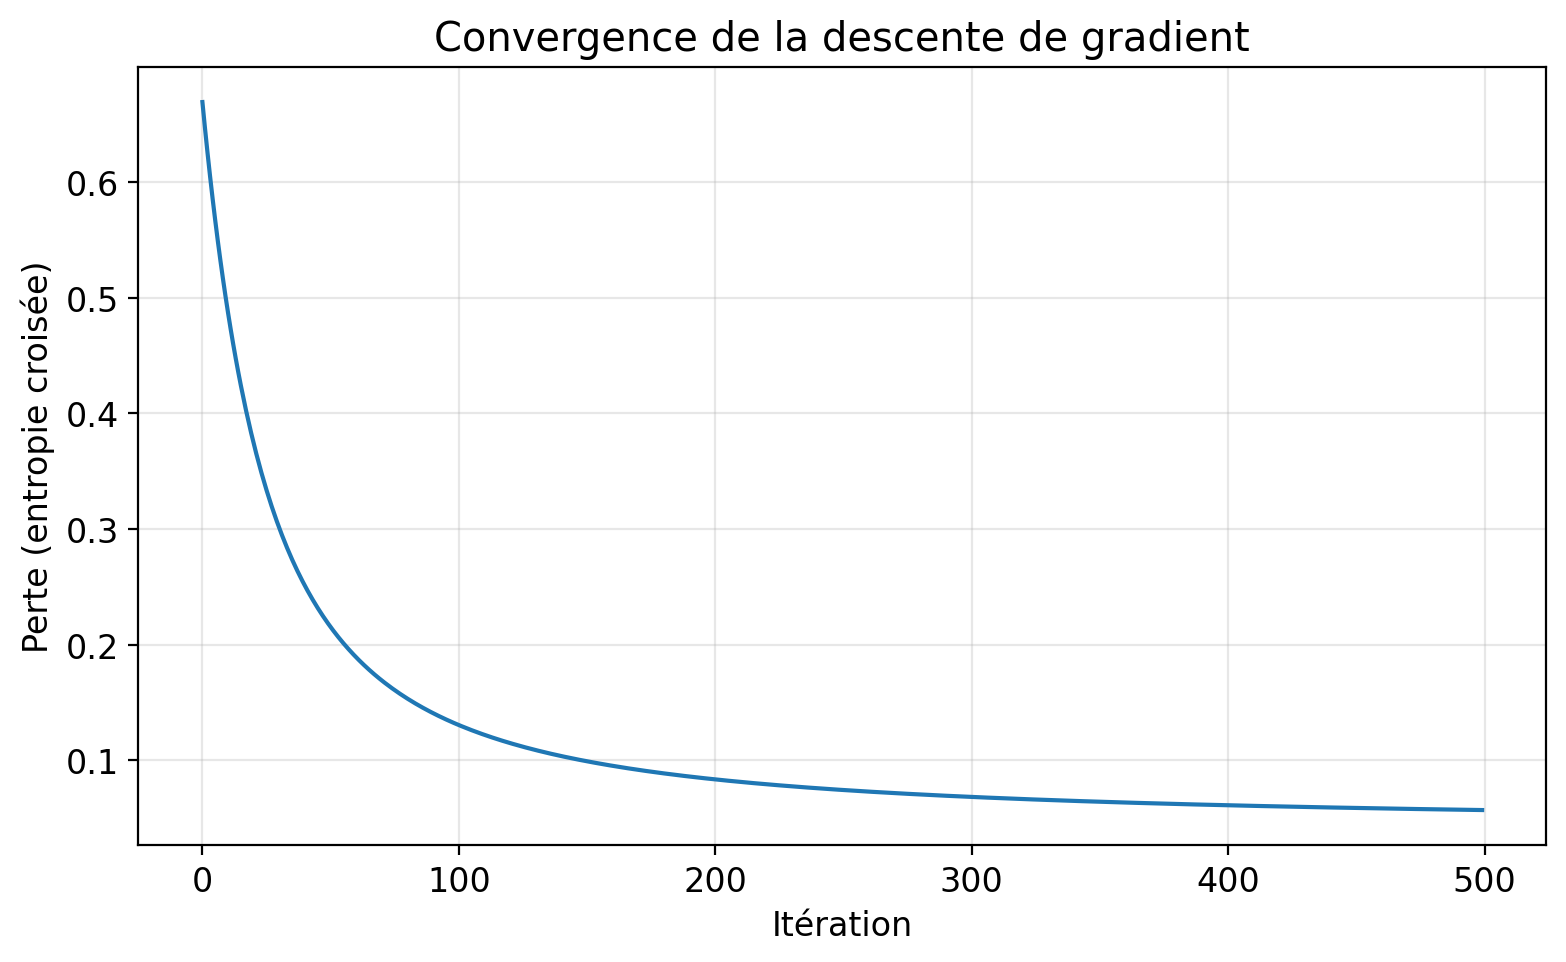

In [150]:
# Test sur la prédiction des événements de pointe
# Caractéristiques pour classification
features_clf = ['temperature_ext', 'heure_sin', 'heure_cos', 'est_weekend']

X_train_clf = train[features_clf].values
y_train_clf = train['evenement_pointe'].values
X_test_clf = test[features_clf].values
y_test_clf = test['evenement_pointe'].values

# Normaliser (recommandé pour la descente de gradient)
scaler = StandardScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# Entraîner votre modèle
beta_log, losses = logistic_fit_gd(X_train_clf_scaled, y_train_clf, lr=0.1, n_iter=500, verbose=True)

# Tracer la courbe de convergence (s'affiche une fois logistic_fit_gd implémenté)
if beta_log is not None and losses:
    plt.figure(figsize=(8, 5))
    plt.plot(losses)
    plt.xlabel('Itération')
    plt.ylabel('Perte (entropie croisée)')
    plt.title('Convergence de la descente de gradient')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print("Complétez logistic_fit_gd (Partie 2) pour voir la courbe de convergence.")

In [151]:
# Évaluation (s'affiche une fois logistic_predict_proba implémenté)
proba_train = logistic_predict_proba(X_train_clf_scaled, beta_log) if beta_log is not None else None
proba_test = logistic_predict_proba(X_test_clf_scaled, beta_log) if beta_log is not None else None

if proba_train is not None and proba_test is not None:
    y_pred_train = (proba_train >= 0.5).astype(int)
    y_pred_test = (proba_test >= 0.5).astype(int)
    print("Évaluation de votre régression logistique:")
    print(f"  Accuracy (train): {accuracy_score(y_train_clf, y_pred_train):.4f}")
    print(f"  Accuracy (test): {accuracy_score(y_test_clf, y_pred_test):.4f}")
    print(f"\nRapport de classification (test):")
    print(classification_report(y_test_clf, y_pred_test, target_names=['Normal', 'Pointe']))
else:
    print("Complétez logistic_fit_gd et logistic_predict_proba (Partie 2) pour voir l'évaluation.")

Évaluation de votre régression logistique:
  Accuracy (train): 0.9905
  Accuracy (test): 0.9840

Rapport de classification (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      1726
      Pointe       0.00      0.00      0.00        28

    accuracy                           0.98      1754
   macro avg       0.49      0.50      0.50      1754
weighted avg       0.97      0.98      0.98      1754



---

## Partie 3: Ingénierie des caractéristiques (15%)

**À partir de maintenant, vous pouvez utiliser scikit-learn.**

Créez des caractéristiques temporelles pour améliorer le modèle de régression.

### Caractéristiques à implémenter:

1. **Retards (lags)**: consommation aux heures précédentes
2. **Statistiques glissantes**: moyenne mobile, écart-type mobile
3. **Interactions**: température × heure, etc.

Implémentez **au moins 3 nouvelles caractéristiques**.

In [152]:
def creer_caracteristiques(df):
    """
    Crée des caractéristiques supplémentaires.
    
    VOUS DEVEZ IMPLÉMENTER AU MOINS 3 NOUVELLES CARACTÉRISTIQUES.
    
    Idées:
    - Retards: df['energie_kwh'].shift(1), shift(24)
    - Moyennes mobiles: df['energie_kwh'].rolling(6).mean()
    - Interactions: df['temperature_ext'] * df['heure_cos']
    - Degré-jours de chauffage: np.maximum(18 - df['temperature_ext'], 0)
    """
    df = df.copy()
    
    # VOTRE CODE ICI
    # Exemple:
    # df['energie_lag1'] = df['energie_kwh'].shift(1)
    # df['energie_rolling_6h'] = df['energie_kwh'].rolling(6).mean()
    # df['temp_heure_interaction'] = df['temperature_ext'] * df['heure_cos']
    
    df["energie_kwh_log"] = np.log1p(df["energie_kwh"])
    df["temperature_ext_sq"] = df["temperature_ext"] ** 2
    df["clients_connectes_sq"] = df["clients_connectes"] ** 2
    df["clients_connectes_cu"] = df["clients_connectes"] ** 3
    df["tstats_intelligents_connectes_sq"] = df["tstats_intelligents_connectes"] ** 2
    df["tstats_intelligents_connectes_cu"] = df["tstats_intelligents_connectes"] ** 3

    df['temp_heure_interaction'] = df['temperature_ext'] * df['heure_cos']
    df["temp_clients_interaction"] = df['temperature_ext'] * df['clients_connectes']
    df["temp_tstats_interaction"] = df['temperature_ext'] * df['tstats_intelligents_connectes_sq']
    df["tstats_clients_interaction"] = df['tstats_intelligents_connectes_sq'] * df['clients_connectes']

    df["temperature_ext_lag1"] = df["temperature_ext"].shift(1)
    df["temperature_ext_lag24"] = df["temperature_ext"].shift(24)
    df["temperature_ext_rolling_6h"] = df["temperature_ext"].rolling(6).mean()

    return df

# Appliquer aux données
train_eng = creer_caracteristiques(train)
test_eng = creer_caracteristiques(test)

# Supprimer les lignes avec NaN (dues aux retards)
train_eng = train_eng.dropna()
test_eng = test_eng.dropna()

print(f"Nouvelles colonnes: {[c for c in train_eng.columns if c not in train.columns]}")

Nouvelles colonnes: ['energie_kwh_log', 'temperature_ext_sq', 'clients_connectes_sq', 'clients_connectes_cu', 'tstats_intelligents_connectes_sq', 'tstats_intelligents_connectes_cu', 'temp_heure_interaction', 'temp_clients_interaction', 'temp_tstats_interaction', 'tstats_clients_interaction', 'temperature_ext_lag1', 'temperature_ext_lag24', 'temperature_ext_rolling_6h']


---

## Partie 4: Régression Ridge (15%)

Avec plusieurs caractéristiques corrélées, la régularisation devient utile.

1. Entraînez un modèle Ridge avec validation croisée pour choisir λ
2. Comparez les performances avec OLS
3. Analysez comment les coefficients changent

In [153]:
# Définissez vos caractéristiques pour la régression
# MODIFIEZ CETTE LISTE selon vos caractéristiques créées en Partie 3
# IMPORTANT: clients_connectes est une variable très importante!
features_reg = [
    # Saisonalité:
    'mois_sin', 'mois_cos','heure_sin', 'heure_cos',
    # Caractéristiques bruts:
    'clients_connectes','tstats_intelligents_connectes', 'temperature_ext','irradiance_solaire', 'neige'
    # Caractéristiques créées:
    'temperature_ext_sq', 'clients_connectes_sq', 'clients_connectes_cu', 'tstats_intelligents_connectes_sq', 'tstats_intelligents_connectes_cu',
    'temp_heure_interaction', 'temp_clients_interaction', 'temp_tstats_interaction', 'tstats_clients_interaction',
    'temperature_ext_lag1', 'temperature_ext_lag24', 'temperature_ext_rolling_6h'
]

# Vérifier que toutes les colonnes existent
features_disponibles = [f for f in features_reg if f in train_eng.columns]
print(f"Caractéristiques utilisées: {len(features_disponibles)}")

X_train_reg = train_eng[features_disponibles].values
y_train_reg = train_eng['energie_kwh_log'].values
X_test_reg = test_eng[features_disponibles].values
y_test_reg = test_eng['energie_kwh_log'].values

Caractéristiques utilisées: 19


In [154]:
# Modèle OLS (baseline)
model_ols = LinearRegression()
model_ols.fit(X_train_reg, y_train_reg)
y_pred_ols = model_ols.predict(X_test_reg)

print("OLS (baseline):")
print(f"  R² train: {model_ols.score(X_train_reg, y_train_reg):.4f}")
print(f"  R² test:  {r2_score(y_test_reg, y_pred_ols):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_reg, y_pred_ols)):.4f}")

OLS (baseline):
  R² train: 0.8348
  R² test:  0.4530
  RMSE test: 0.4556


In [155]:
# Modèle Ridge avec validation croisée
# ATTENTION: Utilisez TimeSeriesSplit pour les données temporelles!
from sklearn.model_selection import TimeSeriesSplit
alphas = [0.01, 0.1, 1, 10, 100, 1000]
tscv = TimeSeriesSplit(n_splits=5)

model_ridge = RidgeCV(alphas=alphas, cv=tscv)
model_ridge.fit(X_train_reg, y_train_reg)
y_pred_ridge = model_ridge.predict(X_test_reg)

print(f"\nRidge (λ={model_ridge.alpha_}):")
print(f"  R² train: {model_ridge.score(X_train_reg, y_train_reg):.4f}")
print(f"  R² test:  {r2_score(y_test_reg, y_pred_ridge):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)):.4f}")


Ridge (λ=100.0):
  R² train: 0.8334
  R² test:  0.4914
  RMSE test: 0.4393


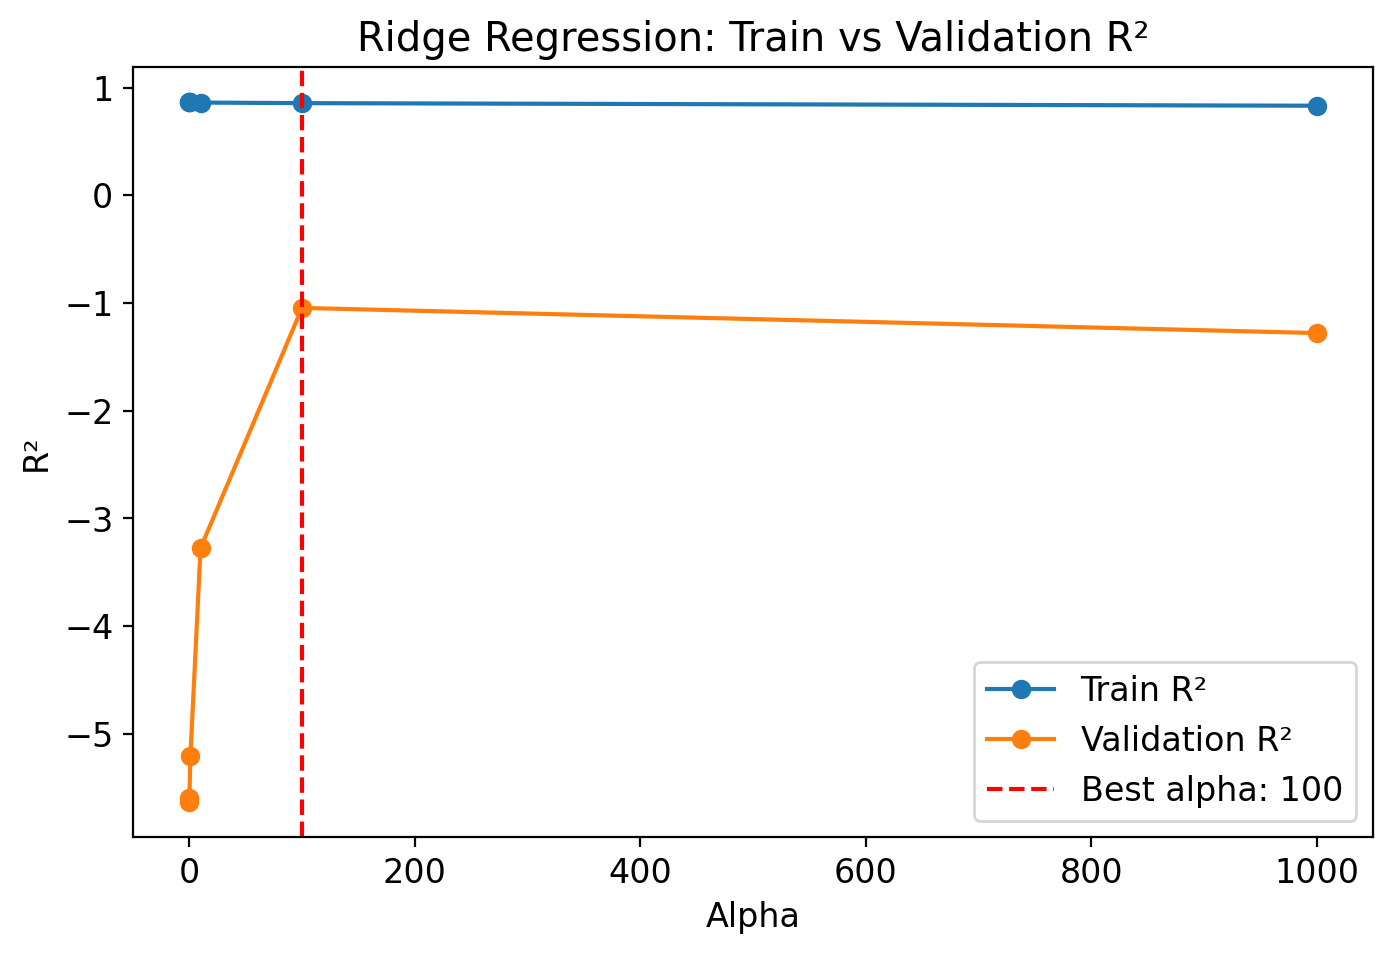

In [156]:
# Tracer la courbe de validation pour Ridge et indiquer le meilleur alpha
ridge_train_scores = []
ridge_val_scores = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in tscv.split(X_train_reg):
        model.fit(X_train_reg[train_idx], y_train_reg[train_idx])
        train_scores.append(model.score(X_train_reg[train_idx], y_train_reg[train_idx]))
        val_scores.append(model.score(X_train_reg[val_idx], y_train_reg[val_idx]))
    ridge_train_scores.append(np.mean(train_scores))
    ridge_val_scores.append(np.mean(val_scores))
plt.figure(figsize=(8, 5))
plt.plot(alphas, ridge_train_scores, label='Train R²', marker='o')
plt.plot(alphas, ridge_val_scores, label='Validation R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Ridge Regression: Train vs Validation R²')
plt.legend()
best_alpha = alphas[np.argmax(ridge_val_scores)]
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha}')
plt.legend()
plt.show()

In [157]:
# Comparaison des coefficients OLS vs Ridge
coef_comparison = pd.DataFrame({
    'Caractéristique': features_disponibles,
    'OLS': model_ols.coef_,
    'Ridge': model_ridge.coef_
})
coef_comparison['Réduction (%)'] = 100 * (1 - np.abs(coef_comparison['Ridge']) / (np.abs(coef_comparison['OLS']) + 1e-8))
coef_comparison = coef_comparison.sort_values('Réduction (%)', ascending=False)

print("\nComparaison des coefficients (triés par réduction):")
print(coef_comparison.to_string(index=False))


Comparaison des coefficients (triés par réduction):
                 Caractéristique           OLS         Ridge  Réduction (%)
            clients_connectes_cu  3.061014e-05 -2.705675e-06      91.163739
            clients_connectes_sq -6.560459e-03 -2.399981e-03      63.417537
tstats_intelligents_connectes_sq  1.986135e-04  8.093124e-05      59.253954
               clients_connectes  5.452573e-01  2.794399e-01      48.750826
   tstats_intelligents_connectes -9.693097e-02 -4.980339e-02      48.619743
                 temperature_ext -2.078511e-02 -1.555031e-02      25.185397
                        mois_sin  1.124284e-01  8.801097e-02      21.718226
                        mois_cos  2.147835e-01  1.946733e-01       9.363002
              irradiance_solaire -1.935522e-04 -1.846462e-04       4.606278
                       heure_cos -2.077568e-01 -1.987424e-01       4.338941
                       heure_sin -2.190298e-01 -2.148555e-01       1.905839
            temperature_ext_lag1  8

**Questions pour l'entrevue orale**:
- Pourquoi Ridge aide-t-il quand les caractéristiques sont corrélées?
- Quelle caractéristique a été la plus réduite? Pourquoi?
- Comment interpréter Ridge comme estimation MAP?

---

## Partie 5: Sous-tâche de classification (15%)

Entraînez un classifieur pour prédire les événements de pointe, puis utilisez la probabilité prédite comme caractéristique pour la régression.

**Étapes**:
1. Entraîner LogisticRegression sur `evenement_pointe`
2. Extraire `P(pointe)` pour chaque observation
3. Ajouter cette probabilité comme caractéristique pour Ridge

In [158]:
vars_importantes = coef_comparison[coef_comparison['Réduction (%)'] < 50]['Caractéristique'].tolist()
print(f"\nVariables les moins pénalisées par Ridge (réduction < 50%): {vars_importantes}")



Variables les moins pénalisées par Ridge (réduction < 50%): ['clients_connectes', 'tstats_intelligents_connectes', 'temperature_ext', 'mois_sin', 'mois_cos', 'irradiance_solaire', 'heure_cos', 'heure_sin', 'temperature_ext_lag1', 'temperature_ext_rolling_6h', 'temperature_ext_lag24', 'tstats_intelligents_connectes_cu', 'temp_heure_interaction', 'temp_tstats_interaction', 'temp_clients_interaction', 'tstats_clients_interaction']


In [159]:
# Caractéristiques pour la classification
# Utilisez des caractéristiques qui ne "trichent" pas (pas de consommation passée pour prédire la pointe)
features_pointe = ['temperature_ext', 'vitesse_vent', 'heure_sin', 'heure_cos', 'clients_connectes','neige', 'temp_heure_interaction']

X_train_pointe = train_eng[features_pointe].values
y_train_pointe = train_eng['evenement_pointe'].values
X_test_pointe = test_eng[features_pointe].values
y_test_pointe = test_eng['evenement_pointe'].values

# Entraîner le classifieur
clf_pointe = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_pointe.fit(X_train_pointe, y_train_pointe)

# Évaluation
print("Classification des événements de pointe:")
print(f"  Accuracy (train): {clf_pointe.score(X_train_pointe, y_train_pointe):.4f}")
print(f"  Accuracy (test): {clf_pointe.score(X_test_pointe, y_test_pointe):.4f}")

Classification des événements de pointe:
  Accuracy (train): 0.8523
  Accuracy (test): 0.9410


In [160]:
# Extraire les probabilités
train_eng['P_pointe'] = clf_pointe.predict_proba(X_train_pointe)[:, 1]
test_eng['P_pointe'] = clf_pointe.predict_proba(X_test_pointe)[:, 1]

print(f"Distribution de P(pointe):")
print(f"  Train: moyenne={train_eng['P_pointe'].mean():.3f}, std={train_eng['P_pointe'].std():.3f}")
print(f"  Test:  moyenne={test_eng['P_pointe'].mean():.3f}, std={test_eng['P_pointe'].std():.3f}")

Distribution de P(pointe):
  Train: moyenne=0.189, std=0.279
  Test:  moyenne=0.082, std=0.191


**Question pour l'entrevue**: Pourquoi utiliser P(pointe) au lieu d'un indicateur 0/1?

---

## Partie 6: Modèle combiné (10%)

Assemblez le modèle final en ajoutant `P_pointe` comme caractéristique.

In [161]:
# Caractéristiques finales (avec P_pointe)
features_final = features_disponibles + ['P_pointe']

X_train_final = train_eng[features_final].values
y_train_final = train_eng['energie_kwh_log'].values
X_test_final = test_eng[features_final].values
y_test_final = test_eng['energie_kwh_log'].values

# Modèle Ridge final
alphas_final = [0.01, 0.1, 1, 10, 100, 1000]
model_final = RidgeCV(alphas=alphas_final, cv=TimeSeriesSplit(n_splits=5))
model_final.fit(X_train_final, y_train_final)
y_pred_final = model_final.predict(X_test_final)

print("Modèle final (Ridge + P_pointe):")
print(f"  λ sélectionné: {model_final.alpha_}")
print(f"  R² train: {model_final.score(X_train_final, y_train_final):.4f}")
print(f"  R² test:  {r2_score(y_test_final, y_pred_final):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.4f}")

Modèle final (Ridge + P_pointe):
  λ sélectionné: 100.0
  R² train: 0.8375
  R² test:  0.5168
  RMSE test: 0.4282


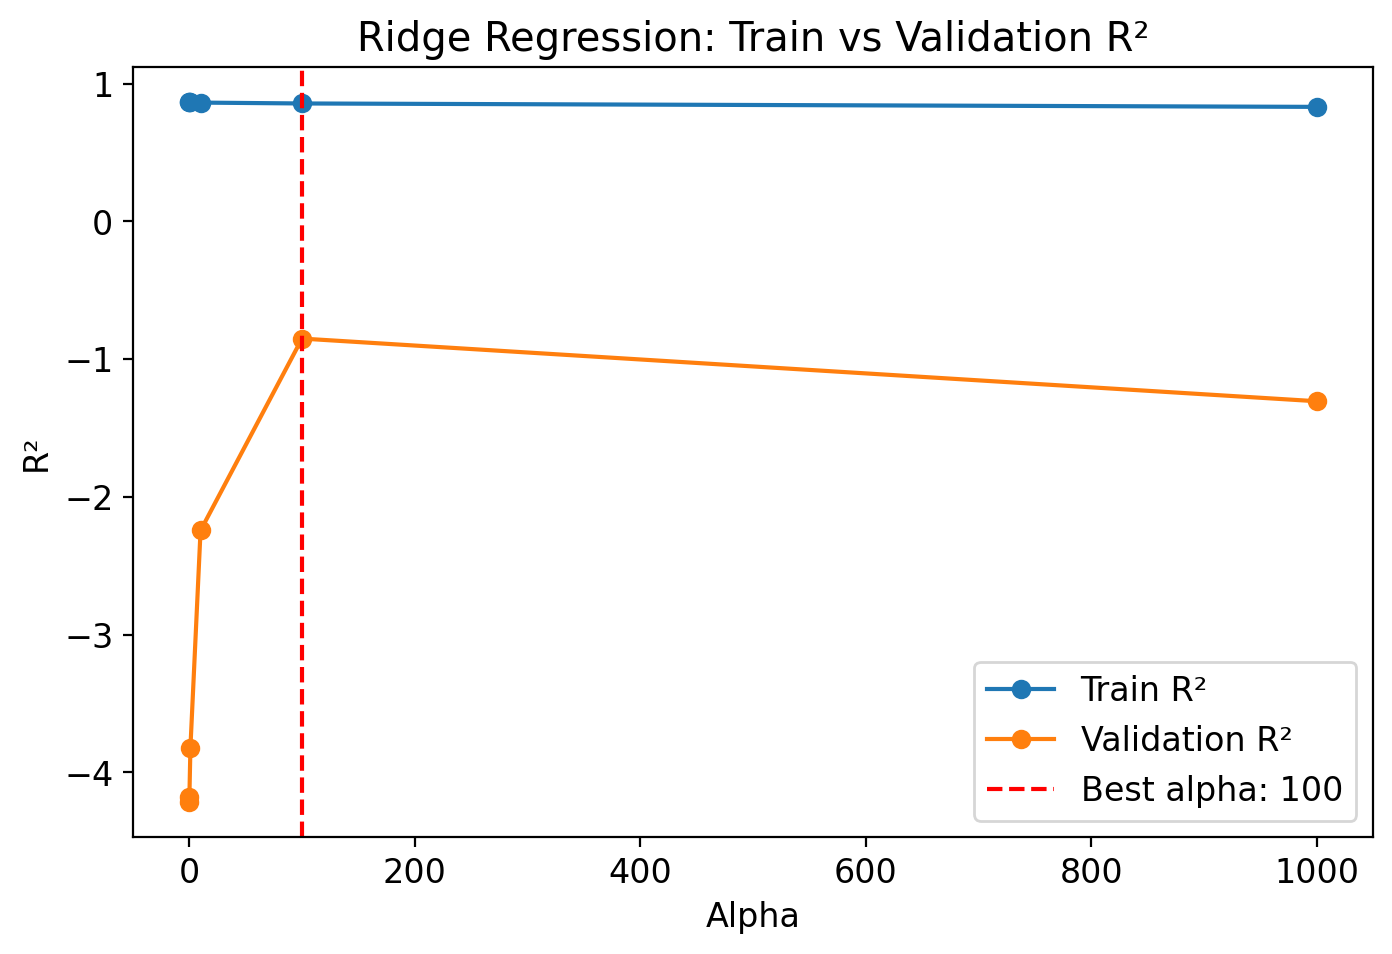

In [162]:
# Tracer la courbe de validation pour Ridge et indiquer le meilleur alpha
ridge_train_scores = []
ridge_val_scores = []
for alpha in alphas_final:
    model = Ridge(alpha=alpha)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in tscv.split(X_train_final):
        model.fit(X_train_final[train_idx], y_train_final[train_idx])
        train_scores.append(model.score(X_train_final[train_idx], y_train_final[train_idx]))
        val_scores.append(model.score(X_train_final[val_idx], y_train_final[val_idx]))
    ridge_train_scores.append(np.mean(train_scores))
    ridge_val_scores.append(np.mean(val_scores))
plt.figure(figsize=(8, 5))
plt.plot(alphas_final, ridge_train_scores, label='Train R²', marker='o')
plt.plot(alphas_final, ridge_val_scores, label='Validation R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Ridge Regression: Train vs Validation R²')
plt.legend()
best_alpha = alphas_final[np.argmax(ridge_val_scores)]
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha}')
plt.legend()
plt.show()

In [163]:
# Comparaison: avec vs sans P_pointe
print("\n=== Récapitulatif ===")
print(f"OLS baseline:     R² = {r2_score(y_test_reg, y_pred_ols):.4f}")
print(f"Ridge:            R² = {r2_score(y_test_reg, y_pred_ridge):.4f}")
print(f"Ridge + P_pointe: R² = {r2_score(y_test_final, y_pred_final):.4f}")
print(f"\nAmélioration due à P_pointe: +{100*(r2_score(y_test_final, y_pred_final) - r2_score(y_test_reg, y_pred_ridge)):.2f}%")


=== Récapitulatif ===
OLS baseline:     R² = 0.4530
Ridge:            R² = 0.4914
Ridge + P_pointe: R² = 0.5168

Amélioration due à P_pointe: +2.54%


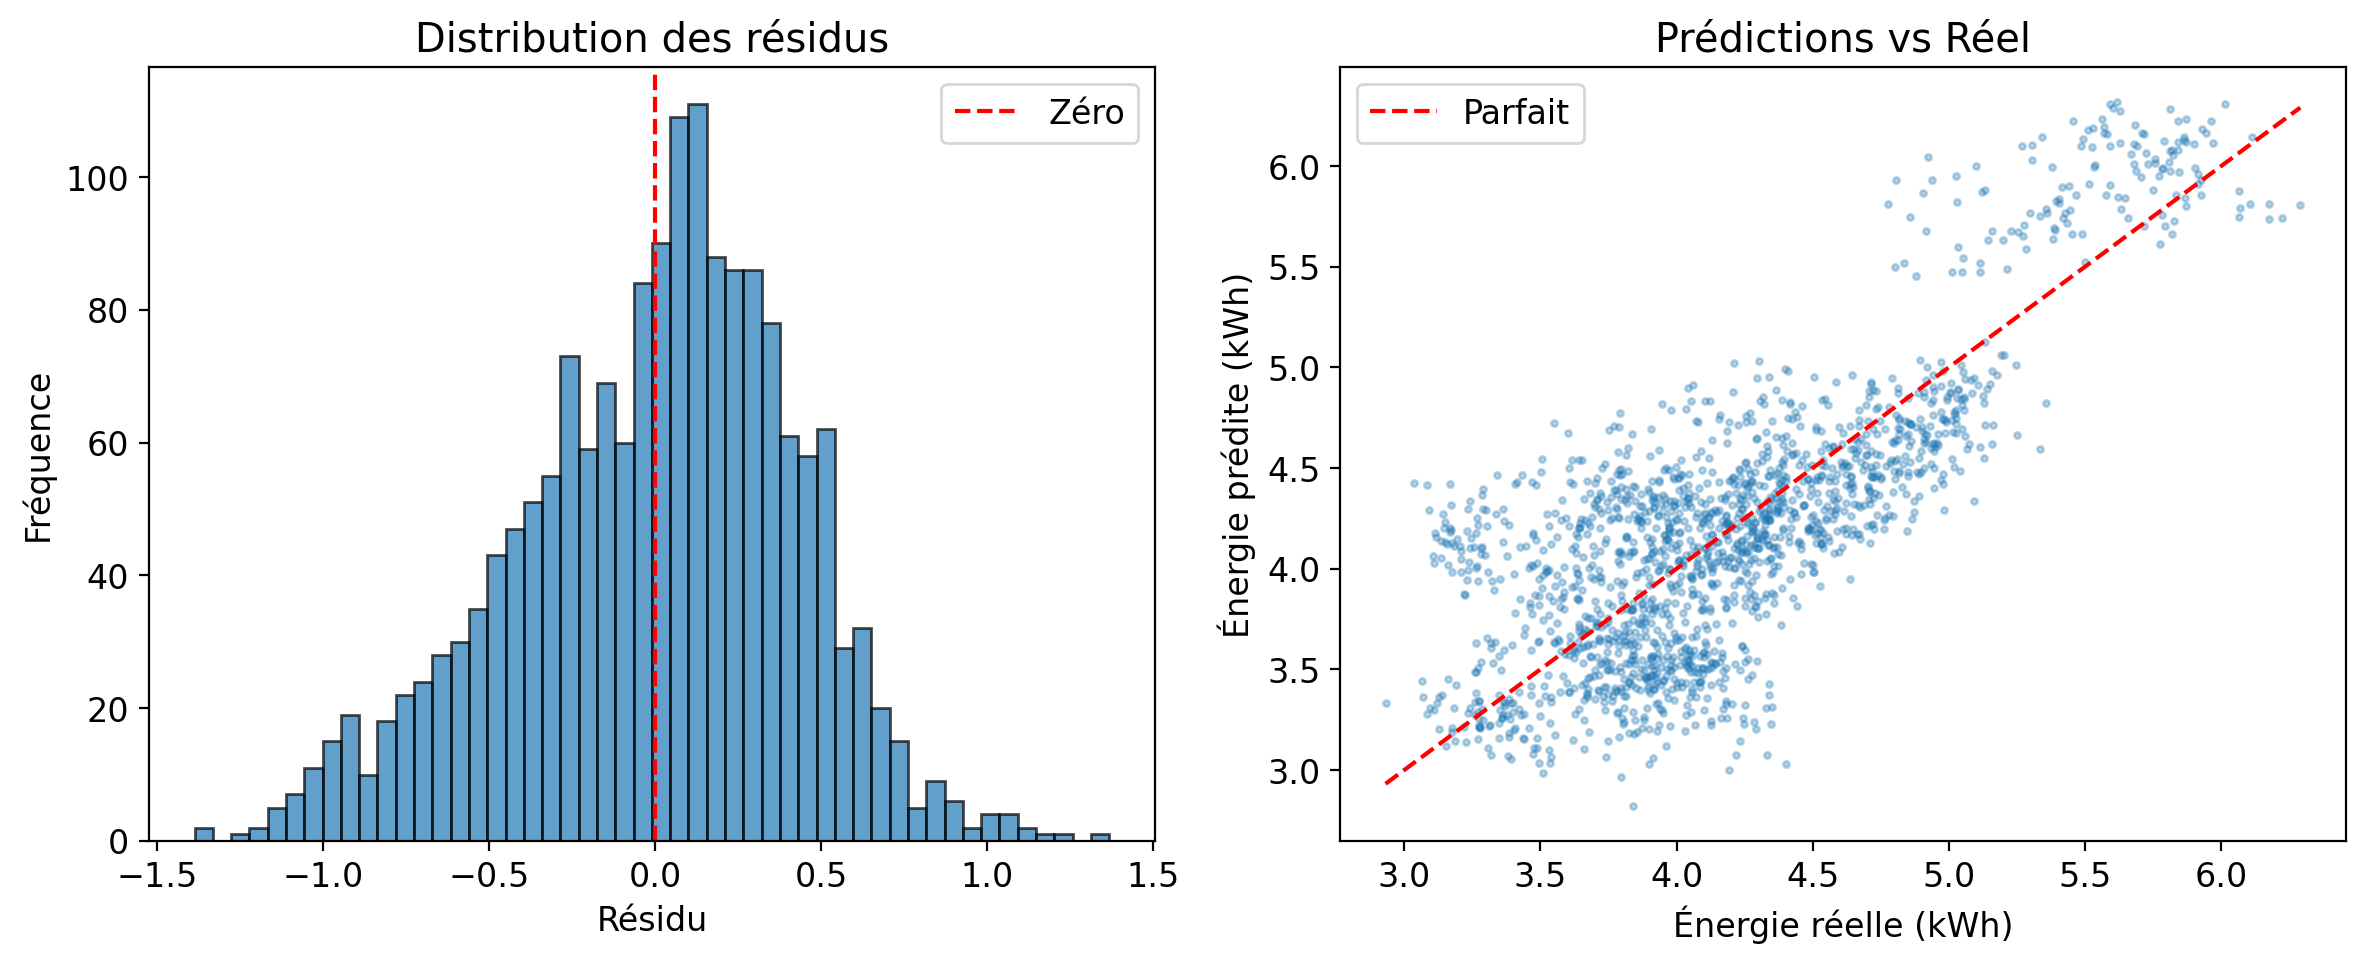

In [164]:
# Visualisation des résidus
residus = y_test_final - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme des résidus
axes[0].hist(residus, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', label='Zéro')
axes[0].set_xlabel('Résidu')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des résidus')
axes[0].legend()

# Prédictions vs réel
axes[1].scatter(y_test_final, y_pred_final, alpha=0.3, s=5)
axes[1].plot([y_test_final.min(), y_test_final.max()], 
             [y_test_final.min(), y_test_final.max()], 'r--', label='Parfait')
axes[1].set_xlabel('Énergie réelle (kWh)')
axes[1].set_ylabel('Énergie prédite (kWh)')
axes[1].set_title('Prédictions vs Réel')
axes[1].legend()

plt.tight_layout()

In [165]:
vars_importantes

['clients_connectes',
 'tstats_intelligents_connectes',
 'temperature_ext',
 'mois_sin',
 'mois_cos',
 'irradiance_solaire',
 'heure_cos',
 'heure_sin',
 'temperature_ext_lag1',
 'temperature_ext_rolling_6h',
 'temperature_ext_lag24',
 'tstats_intelligents_connectes_cu',
 'temp_heure_interaction',
 'temp_tstats_interaction',
 'temp_clients_interaction',
 'tstats_clients_interaction']

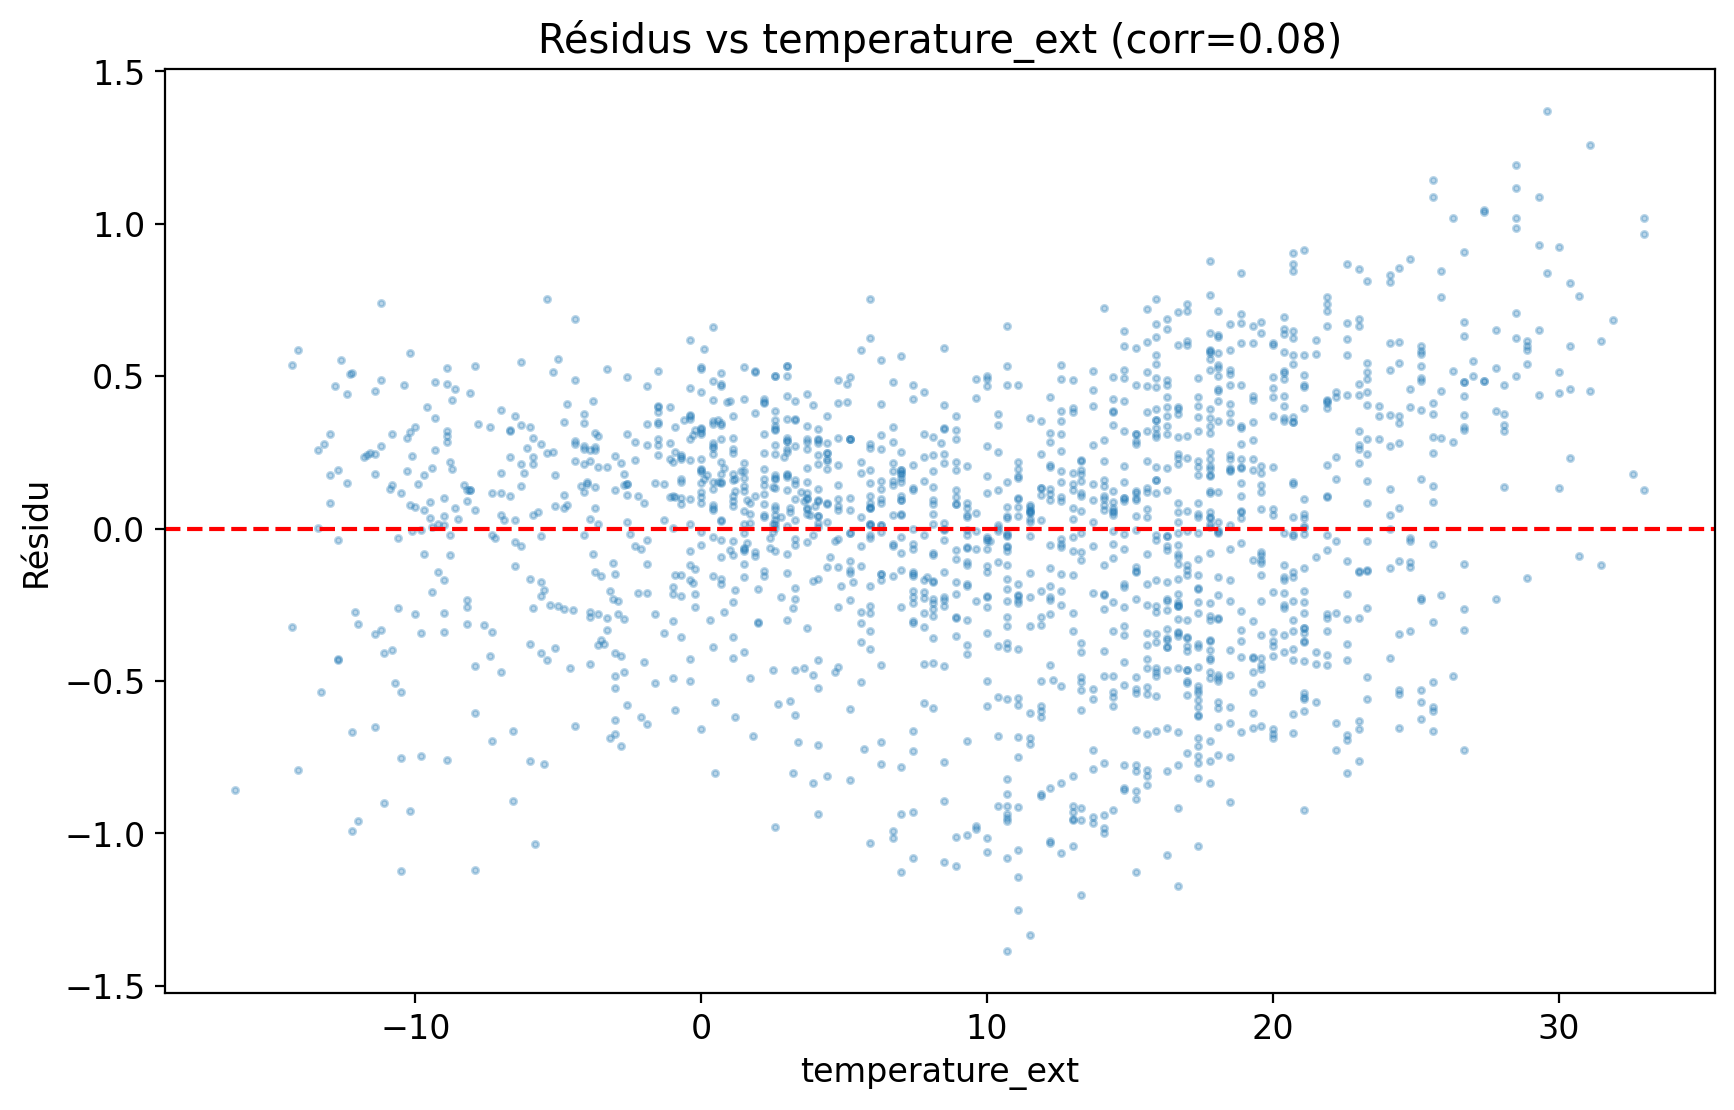

In [166]:
# plot rédus vs var
var = 'temperature_ext'
plt.figure()
plt.scatter(test_eng[var], residus, alpha=0.3, s=5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel(var)
plt.ylabel('Résidu')
plt.title(f'Résidus vs {var}')
cor = np.corrcoef(test_eng[var], residus)[0,1]
plt.title(f'Résidus vs {var} (corr={cor:.2f})')
plt.show()

---

## Partie 7: Extension (10%) - Choisir UNE option

### Option A: Données météorologiques externes
Utilisez la bibliothèque `meteostat` pour ajouter des données météo supplémentaires (ex: pression atmosphérique, point de rosée).

### Option B: Classification multiclasse
Au lieu de binaire (pointe/normal), créez 3+ classes de consommation (faible/moyenne/élevée) et utilisez softmax.

### Option C: Analyse d'erreur approfondie
Identifiez quand le modèle fait le plus d'erreurs et proposez des améliorations.

In [167]:
# VOTRE EXTENSION ICI
# Indiquez quelle option vous avez choisie et pourquoi.

# Option choisie: ___
# Justification: ___

In [168]:
train_eng_improved = train_eng.copy()
test_eng_improved  = test_eng.copy()

# Nettoyage timestamps
for df in (train_eng_improved, test_eng_improved):
    df["horodatage_local"] = pd.to_datetime(df["horodatage_local"]).dt.tz_localize(None)

# Période globale
start = min(train_eng_improved["horodatage_local"].min(),
            test_eng_improved["horodatage_local"].min())

end   = max(train_eng_improved["horodatage_local"].max(),
            test_eng_improved["horodatage_local"].max())

In [169]:
# Point de référence (Montréal - centre-ville; tu peux aussi mettre Trudeau directement)
mtl = ms.Point(45.5017, -73.5673)

# Trouver la station la plus proche
stations = ms.stations.nearby(mtl)   
i = 0
# afficher les 10 stations les plus proches
print("Stations météorologiques les plus proches de Montréal:")
for i in range(min(10, len(stations))):
    print(f"{i}. {stations.iloc[i]['name']} ({stations.iloc[i]['country']}, {stations.iloc[i]['region']}) - Distance: {stations.iloc[i]['distance']:.1f} km - ID: {stations.index[i]}")

Stations météorologiques les plus proches de Montréal:
0. Montreal McTavish (CA, QC) - Distance: 1007.7 km - ID: 71612
1. Cote St Catherine / Sainte-Catherine (CA, QC) - Distance: 9451.7 km - ID: CWCS0
2. Ile Charron / Boucherville (CA, QC) - Distance: 10872.3 km - ID: CWVZ0
3. Montreal Saint Hubert Airport (CA, QC) - Distance: 11657.0 km - ID: 71371
4. Montreal International Airport (CA, QC) - Distance: 13917.0 km - ID: 71627
5. Montreal/pierre Elliott Trudeau Intl (CA, QC) - Distance: 13917.0 km - ID: SOK6B
6. Laprairie (CA, QC) - Distance: 17259.0 km - ID: 3NDQ8
7. Auteuil (CA, QC) - Distance: 20791.5 km - ID: ADI6G
8. Ste Genevieve (CA, QC) - Distance: 22033.4 km - ID: N4D49
9. Riviere Des Prairies (CA, QC) - Distance: 22663.1 km - ID: JVOIG


In [170]:
station_id = stations.index[4]  # Choisir la station Mtl Trudeau
df = ms.hourly(station_id, start, end).fetch()
df.head()

,temp,rhum,prcp,snwd,wdir,wspd,wpgt,pres,tsun,cldc,coco
time,,,,,,,,,,,
2022-01-02 22:00:00,-7.0,73,<NA>,<NA>,260,7.0,<NA>,1013.9,<NA>,<NA>,4
2022-01-02 23:00:00,-7.6,71,<NA>,<NA>,260,15.0,<NA>,1015.5,<NA>,<NA>,3
2022-01-03 00:00:00,-8.3,69,<NA>,<NA>,270,13.0,<NA>,1016.7,<NA>,7,3
2022-01-03 01:00:00,-10.1,68,<NA>,<NA>,280,11.0,<NA>,1017.6,<NA>,<NA>,2
2022-01-03 02:00:00,-11.5,74,<NA>,<NA>,280,13.0,<NA>,1019.0,<NA>,2,2


In [171]:
# Source des données: https://dev.meteostat.net/api/point/hourly https://dev.meteostat.net/parameters?g=daily&d=1

variables_meteo ={
    "time" : "horodatage_local",
    "wdir": "direction_vent_deg",
    "pres": "pression_atmospherique_hpa"
}

#  Récupérer les données horaires
meteo_hourly = ms.hourly(station_id, start, end).fetch()
meteo_hourly = meteo_hourly.reset_index().rename(columns=variables_meteo).loc[:, variables_meteo.values()]

# Merge
train_eng_improved = train_eng_improved.merge(
    meteo_hourly, on="horodatage_local", how="left"
)
test_eng_improved = test_eng_improved.merge(
    meteo_hourly, on="horodatage_local", how="left"
)
print("Nouvelles colonnes météo ajoutées:", list(variables_meteo.values())[1:])

# Vérifier les valeurs manquantes
print("Valeurs manquantes après merge (train):")
print(train_eng_improved[list(variables_meteo.values())[1:]].isna().sum())
print("Valeurs manquantes après merge (test):")
print(test_eng_improved[list(variables_meteo.values())[1:]].isna().sum())

Nouvelles colonnes météo ajoutées: ['direction_vent_deg', 'pression_atmospherique_hpa']
Valeurs manquantes après merge (train):
direction_vent_deg            0
pression_atmospherique_hpa    0
dtype: int64
Valeurs manquantes après merge (test):
direction_vent_deg            0
pression_atmospherique_hpa    0
dtype: int64


In [172]:
# Modèle Ridge amélioré avec données météorologiques
features_improved = features_final + list(variables_meteo.values())[1:]  # Exclure 'horodatage_local'

X_train_improved = train_eng_improved[features_improved].values
X_test_improved  = test_eng_improved[features_improved].values
y_train_improved = train_eng_improved['energie_kwh_log'].values
y_test_improved  = test_eng_improved['energie_kwh_log'].values

alphas_improved = [0.01, 0.1, 1, 10, 100, 1000]
model_improved = RidgeCV(alphas=alphas_improved, cv=TimeSeriesSplit(n_splits=5))
model_improved.fit(X_train_improved, y_train_improved)
y_pred_improved = model_improved.predict(X_test_improved)
print("Modèle amélioré (Ridge + données météo):")
print(f"  λ sélectionné: {model_improved.alpha_}")
print(f"  R² train: {model_improved.score(X_train_improved, y_train_improved):.4f}")
print(f"  R² test:  {r2_score(y_test_improved, y_pred_improved):.4f}")
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_test_improved, y_pred_improved)):.4f}")

# Comparaison complète
print("\n=== Comparaison finale ===")
print(f"OLS baseline:              R² = {r2_score(y_test_reg, y_pred_ols):.4f}")
print(f"Ridge:                     R² = {r2_score(y_test_reg, y_pred_ridge):.4f}")
print(f"Ridge + P_pointe:          R² = {r2_score(y_test_final, y_pred_final):.4f}")
print(f"Ridge + P_pointe + Meteo:  R² = {r2_score(y_test_improved, y_pred_improved):.4f}")
print(f"\nAmélioration totale: +{100*(r2_score(y_test_improved, y_pred_improved) - r2_score(y_test_reg, y_pred_final)):.2f}%")

Modèle amélioré (Ridge + données météo):
  λ sélectionné: 100.0
  R² train: 0.8384
  R² test:  0.5188
  RMSE test: 0.4273

=== Comparaison finale ===
OLS baseline:              R² = 0.4530
Ridge:                     R² = 0.4914
Ridge + P_pointe:          R² = 0.5168
Ridge + P_pointe + Meteo:  R² = 0.5188

Amélioration totale: +0.20%


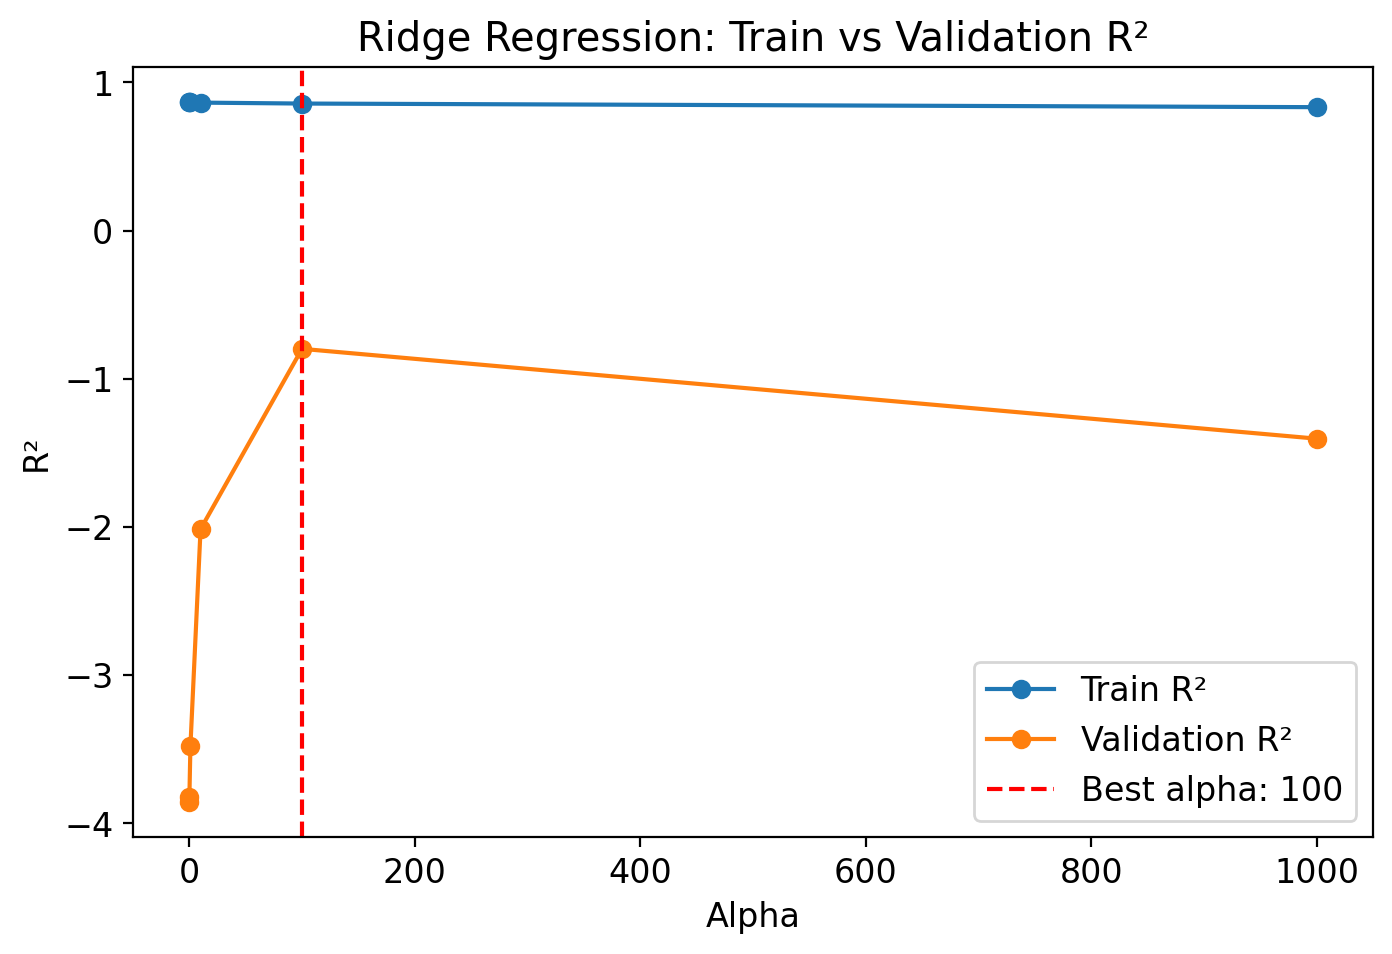

In [174]:
# Tracer la courbe de validation pour Ridge et indiquer le meilleur alpha
ridge_train_scores = []
ridge_val_scores = []
for alpha in alphas_improved:
    model = Ridge(alpha=alpha)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in tscv.split(X_train_improved):
        model.fit(X_train_improved[train_idx], y_train_improved[train_idx])
        train_scores.append(model.score(X_train_improved[train_idx], y_train_improved[train_idx]))
        val_scores.append(model.score(X_train_improved[val_idx], y_train_improved[val_idx]))
    ridge_train_scores.append(np.mean(train_scores))
    ridge_val_scores.append(np.mean(val_scores))
plt.figure(figsize=(8, 5))
plt.plot(alphas_improved, ridge_train_scores, label='Train R²', marker='o')
plt.plot(alphas_improved, ridge_val_scores, label='Validation R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Ridge Regression: Train vs Validation R²')
plt.legend()
best_alpha = alphas_improved[np.argmax(ridge_val_scores)]
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha}')
plt.legend()
plt.show()

---

## Soumission Kaggle

Générez votre fichier de soumission pour la compétition.

In [176]:
# Générer les prédictions pour Kaggle (sur test_kaggle, sans la cible)
# Note: utilisez votre meilleur modèle pour faire ces prédictions
# Exemple avec le modèle final:
# X_kaggle = test_kaggle[features_final].values
# y_pred_kaggle = votre_modele.predict(X_kaggle)

model_choisi = model_improved

test_kaggle_eng =  test_kaggle.copy()

test_kaggle['energie_kwh'] = 0 

test_kaggle_eng = creer_caracteristiques(test_kaggle)

test_kaggle_eng[features_pointe] = test_kaggle_eng[features_pointe].values
test_kaggle_eng['P_pointe'] = clf_pointe.predict_proba(test_kaggle_eng[features_pointe].values)[:, 1]

test_kaggle_eng["horodatage_local"] = pd.to_datetime(test_kaggle_eng["horodatage_local"]).dt.tz_localize(None)
start_kaggle = test_kaggle_eng["horodatage_local"].min()
end_kaggle   = test_kaggle_eng["horodatage_local"].max()
#  Récupérer les données horaires
meteo_kaggle_hourly = ms.hourly(station_id, start_kaggle, end_kaggle).fetch()
meteo_kaggle_hourly = meteo_kaggle_hourly.reset_index().rename(columns=variables_meteo).loc[:, variables_meteo.values()]
test_kaggle_eng = test_kaggle_eng.merge(
    meteo_kaggle_hourly, on="horodatage_local", how="left"
)
# colonnes qui ne sont pas dans features_pointe mais qui sont dans features_improved

X_kaggle = test_kaggle_eng[features_improved].values

# imputation des NaN par la moyenne de chaque colonne (due aux retards)
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train_improved)
X_kaggle_final = imputer.transform(X_kaggle)

y_pred_kaggle = np.expm1(model_choisi.predict(X_kaggle_final))

submission = pd.DataFrame({
    'id': range(len(test_kaggle)),
    'energie_kwh': y_pred_kaggle  
})

submission.to_csv('submission.csv', index=False)
print(f"Fichier de soumission créé: submission.csv ({len(submission)} lignes)")
submission.head()

Fichier de soumission créé: submission.csv (1754 lignes)


,id,energie_kwh
0,0,348.824073
1,1,308.983280
2,2,289.932713
3,3,268.495013
4,4,65.343327


In [178]:
# Générer les prédictions pour Kaggle (sur test_kaggle, sans la cible)
# Note: utilisez votre meilleur modèle pour faire ces prédictions
# Exemple avec le modèle final:
# X_kaggle = test_kaggle[features_final].values
# y_pred_kaggle = votre_modele.predict(X_kaggle)

model_choisi = model_final  # Remplacez par notre meilleur modèle
test_kaggle_eng =  test_kaggle.copy()
test_kaggle['energie_kwh'] = 0 
test_kaggle_eng = creer_caracteristiques(test_kaggle)
test_kaggle_eng['P_pointe'] = clf_pointe.predict_proba(test_kaggle_eng[features_pointe].values)[:, 1]
X_kaggle = test_kaggle_eng[features_final].values
# imputation des NaN par la mediane de chaque colonne (due aux retards)
imputer = SimpleImputer(strategy='median')
X_kaggle_imputed = imputer.fit_transform(X_train_final)
X_kaggle_imputed = imputer.transform(X_kaggle)
y_pred_kaggle = np.expm1(model_choisi.predict(X_kaggle_imputed))

submission = pd.DataFrame({
    'id': range(len(test_kaggle)),
    'energie_kwh': y_pred_kaggle  # Remplacez par vos prédictions sur test_kaggle
})

submission.to_csv('submission.csv', index=False)
print(f"Fichier de soumission créé: submission.csv ({len(submission)} lignes)")
submission.head()

Fichier de soumission créé: submission.csv (1754 lignes)


,id,energie_kwh
0,0,351.285966
1,1,311.496196
2,2,291.543048
3,3,270.316647
4,4,65.509116


In [179]:
print(f"  RMSE test: {np.sqrt(mean_squared_error(y_pred_kaggle, test['energie_kwh'])):.4f}")

  RMSE test: 47.8205


---

## Questions de préparation pour l'entrevue orale

Préparez-vous à répondre à ces questions:

### Fondamentaux
1. Dérivez la solution OLS sur le tableau.
2. Pourquoi avez-vous utilisé une division temporelle et non aléatoire?
3. Que voyez-vous dans vos résidus?

### Régularisation
4. Pourquoi Ridge aide-t-il avec des caractéristiques corrélées?
5. Comment avez-vous choisi λ?
6. Quel coefficient a été le plus réduit? Pourquoi?

### Classification
7. Quelle cible binaire avez-vous choisie? Justifiez.
8. Votre classifieur donne P=0.7. Qu'est-ce que cela signifie?
9. Pourquoi utiliser P(pointe) plutôt qu'un indicateur 0/1?

### Théorie probabiliste
10. Expliquez Ridge comme estimation MAP.
11. Pourquoi la régression logistique minimise-t-elle l'entropie croisée?

### Synthèse
12. Parcourez votre modèle complet étape par étape.
13. Quelle amélioration de R² était la plus importante?
14. Modifiez ce seuil en direct - que prédisez-vous?